# ETL for EDA Crypto

Here, you will find all the steps taken for Extracting, Transforming, and Loading in the data request from coinGecko.com for the upcoming EDA.

##### `Coingecko.com`

An API where you can request information about crypto currencies and more (almost above 10k coins). We are going to focus only on 10 coins. The criteria about the choice will be determined once an exploration of the data from the API were done




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

Pinging the API

In [2]:
endpoint_url = "https://api.coingecko.com/api/v3/ping"

reponse = requests.get(endpoint_url)

if reponse.status_code == 200:
    print(reponse.json())
else:
    print("Error: ", reponse.status_code)

{'gecko_says': '(V3) To the Moon!'}


# Having a look at CoinGecko API

An API requires an endpoint direcoty and maybe parameters. Tha's not the case for the end point currencies and it is needed only the available currencies

#### Coins


Gecko offers literally tons of different coins (10k+)... which is kinda crazy, so, by  now, let's only focus on the treding ones to only pick 10 of them.. and let's search what the end point `search/trending` has for us
![search/trending](images/etl_images/search_trending_ep.JPG)

In [3]:
coingecko = "https://api.coingecko.com/api/v3/"
trend_coins_ep = "search/trending"

trend_coins = requests.get(coingecko + trend_coins_ep).json()
trend_coins

{'coins': [{'item': {'id': 'apecoin',
    'coin_id': 24383,
    'name': 'ApeCoin',
    'symbol': 'APE',
    'market_cap_rank': 66,
    'thumb': 'https://assets.coingecko.com/coins/images/24383/thumb/apecoin.jpg?1647476455',
    'small': 'https://assets.coingecko.com/coins/images/24383/small/apecoin.jpg?1647476455',
    'large': 'https://assets.coingecko.com/coins/images/24383/large/apecoin.jpg?1647476455',
    'slug': 'apecoin',
    'price_btc': 5.889204876048854e-05,
    'score': 0}},
  {'item': {'id': 'sei-network',
    'coin_id': 28205,
    'name': 'Sei',
    'symbol': 'SEI',
    'market_cap_rank': 119,
    'thumb': 'https://assets.coingecko.com/coins/images/28205/thumb/TKmaTqMv_400x400.jpeg?1668395911',
    'small': 'https://assets.coingecko.com/coins/images/28205/small/TKmaTqMv_400x400.jpeg?1668395911',
    'large': 'https://assets.coingecko.com/coins/images/28205/large/TKmaTqMv_400x400.jpeg?1668395911',
    'slug': 'sei',
    'price_btc': 5.708812035157923e-06,
    'score': 1}},


ok.. when I run into this messy view structures.. I just zoom into each level that compose the object, and the output is a simple dictionary.. and let's just get the keys and see what we've got

In [4]:
trend_coins.keys()

dict_keys(['coins', 'nfts', 'exchanges'])

And let's count how many outputs holds heach key

In [5]:
print("Numbers of coins: ", len(trend_coins["coins"]))
print("Numbers of nfts: ", len(trend_coins["nfts"]))
print("Numbers of exhanges: ", len(trend_coins["exchanges"]))

Numbers of coins:  8
Numbers of nfts:  5
Numbers of exhanges:  0


This endpoint also throws ntfs, and by now, they are not requiered


The next transformasion will reshape the dictionary into a pandas DataFrame

In [6]:

coin_list_df = pd.DataFrame(trend_coins["coins"]).rename(columns={"item": "coin_information"})
coin_list_df

,coin_information
0,"{'id': 'apecoin', 'coin_id': 24383, 'name': 'A..."
1,"{'id': 'sei-network', 'coin_id': 28205, 'name'..."
2,"{'id': 'echelon-prime', 'coin_id': 29053, 'nam..."
3,"{'id': 'arbitrum', 'coin_id': 16547, 'name': '..."
4,"{'id': 'akash-network', 'coin_id': 12785, 'nam..."
5,"{'id': 'thorchain', 'coin_id': 6595, 'name': '..."
6,"{'id': 'ethereum', 'coin_id': 279, 'name': 'Et..."
7,"{'id': 'worldcoin-wld', 'coin_id': 31069, 'nam..."


The bellow code extract the key of the dictionary by iterating the items of any dictionary in the early dataframe and use it to create the column, and also map its data taken with `apply.()` and lambda expression

In [7]:
# This simple iterator is for building the dataframe by extracting the keys and assigng them as column name.

for key, value in coin_list_df["coin_information"][0].items():
    
    coin_list_df[key] = coin_list_df["coin_information"].apply(lambda coin: coin[key])


coin_list_df.drop(columns="coin_information", inplace=True)

In [8]:
# Dropping unnecesary columns
coin_list_df.drop(columns=["thumb", "small", "large"], inplace=True)

In [9]:
coin_list_df

,id,coin_id,name,symbol,market_cap_rank,slug,price_btc,score
0,apecoin,24383,ApeCoin,APE,66,apecoin,0.000059,0
1,sei-network,28205,Sei,SEI,119,sei,0.000006,1
2,echelon-prime,29053,Echelon Prime,PRIME,270,echelon-prime,0.000135,2
3,arbitrum,16547,Arbitrum,ARB,39,arbitrum,0.000038,3
4,akash-network,12785,Akash Network,AKT,104,akash-network,0.000058,4
5,thorchain,6595,THORChain,RUNE,71,thorchain,0.000067,5
6,ethereum,279,Ethereum,ETH,2,ethereum,0.063900,6
7,worldcoin-wld,31069,Worldcoin,WLD,157,worldcoin,0.000057,7


#### Getting currencies

From `/simple/supported_vs_currencies` end point

In [10]:
supported_currencies_ep = "simple/supported_vs_currencies"

# No parameters requiered

currencies_df = pd.DataFrame(requests.get(coingecko + supported_currencies_ep).json()).rename(columns={0: "currencies"})

In [11]:
currencies_df[currencies_df["currencies"].str.contains("mx*")] # -> This only try a search for currencies 

,currencies
7,xlm
17,bmd
36,mmk
37,mxn
38,myr


#### Get Data by ID or Contract from `simple/price` endpoint

* Get the current coin's price from the early request of `search/trending` endpoint 

The parameters requiered are:

- ids: id of coins, comma-separated if querying more than 1 coin
- vs_currencies: vs_currency of coins, comma-separated if querying more than 1 vs_currency
- include_market_cap: Set true if Market Capitalization is requiered
- include_24hr_vol: Set true if 24hr volume is required
- include_24hr_change: Set true ig 24hr change is requiered
- include_last_updated_at: Set true if last updated price were requiered
- precision: For the float numbers



In [97]:
# As more than 1 coin are requiered, it is necessary to pass this parameter in the way like "bitcoin,apecoin,etc,etc" This is easy with join to "glue" all the ids
",".join(coin_list_df["id"].tolist())

'apecoin,trust-wallet-token,sei-network,optimism,akash-network,harrypotterobamasonic10in,thorchain,worldcoin-wld'

In [103]:
simple_price_ep = "simple/price"

coin_ids = ",".join(coin_list_df["id"].tolist()) # Gluing ids by ","

simple_price_parameters = {
    "ids": coin_ids,
    "vs_currencies": "usd",
    "include_market_cap": "true",
    "include_24hr_vol": "true",
    "include_24hr_change": "true",
    "include_last_updated_at": "true",
    "precision": "4"
}

# I "packed" the request with the pandas dataframe building
simple_price_of_coins_df = (pd.DataFrame(
    # System request to the API
    requests
    # Asking for an specifict end point and params
    .get(
        coingecko + simple_price_ep, # <-- The endpoint "building"
        params=simple_price_parameters # <-- The prior defined parameters
        ) 
        .json() # <-- Converting the request into a json object
        ).T) # Personnally, it is easier for me set the price, market capitalization, etc.. as features

In [104]:
simple_price_of_coins_df

,usd,usd_market_cap,usd_24h_vol,usd_24h_change,last_updated_at
akash-network,1.3673,2.968118e+08,7.271120e+06,-19.988450,1.692590e+09
apecoin,1.5846,5.847765e+08,3.636426e+07,-1.963795,1.692590e+09
harrypotterobamasonic10in,0.1779,1.740946e+08,9.563699e+06,22.827044,1.692590e+09
optimism,1.4793,1.061141e+09,5.995536e+07,1.112458,1.692590e+09
sei-network,0.1508,2.723610e+08,1.010324e+08,-5.631406,1.692590e+09
thorchain,1.7206,5.176379e+08,1.870956e+08,-1.428752,1.692590e+09
trust-wallet-token,0.8761,3.648457e+08,5.310971e+06,0.582583,1.692590e+09
worldcoin-wld,1.4593,1.854542e+08,3.837721e+07,-3.032219,1.692590e+09


#### Historical Data

These 4 past years have been kind of abnormal since the pandemic took place at the end of 2019. So let's explore those years

The end points used are:

`/coin/...` 

        `/coins/{id}/market_chart`

Let's run a simple attempt to get a historical data from any coin.. later, this will be run through all coins

In [12]:
def market_chart_request(coin_id:str):

    """
    Fetches historical market chart data for a specific cryptocurrency.

    This function retrieves historical market chart data for a given cryptocurrency, specified by its coin_id.

    Parameters:
        coin_id (str): The unique identifier of the cryptocurrency on CoinGecko.

    Returns:
        pd.DataFrame: A DataFrame containing historical market chart data, including date, price, and other metrics.
        
    Raises:
        ValueError: If the provided coin_id is not a string or is empty.

    Note:
        The function uses the CoinGecko API to fetch the historical market chart data.

    Example:
        coin_id = "bitcoin"
        chart_data = market_chart_request(coin_id)
    """
    if not isinstance(coin_id, str) or not coin_id:
        raise ValueError("coin_id should be a non-empty string.")
    
    
    market_chart_ep = f"coins/{coin_id}/market_chart" # -> create our endpoint string

    # The parameters
    market_chart_parameters = {
        "vs_currency": "usd",
        # days parameters give us how many days.. here I will set it up as max to find out what is the biggest range provided
        "days": "max", 
        "interval": "daily",
        "precision": "4"
    }

    return pd.DataFrame(requests.get(coingecko + market_chart_ep, params=market_chart_parameters).json())


In [13]:
market_chart_coin_df = market_chart_request("apecoin")

In [14]:
market_chart_coin_df # -> Each column has its own UNIX imestamp. We ought to re shape and convert, but first, I want to check the date range the end point could throws at the most

,prices,market_caps,total_volumes
0,"[1647475200000, 8.5368]","[1647475200000, 946081401.9243534]","[1647475200000, 1455626533.6918294]"
1,"[1647561600000, 8.5368]","[1647561600000, 946081401.9243534]","[1647561600000, 1455626533.6918294]"
2,"[1647648000000, 12.9887]","[1647648000000, 1740629590.0400217]","[1647648000000, 5214126303.852453]"
3,"[1647734400000, 11.5352]","[1647734400000, 1542254655.9177086]","[1647734400000, 1816679748.2748725]"
4,"[1647820800000, 9.6182]","[1647820800000, 1261482818.2726943]","[1647820800000, 1381888008.2736359]"
...,...,...,...
520,"[1692403200000, 1.5609]","[1692403200000, 574741183.0710272]","[1692403200000, 87480739.62529887]"
521,"[1692489600000, 1.6034]","[1692489600000, 590909814.2500459]","[1692489600000, 42258656.15281304]"
522,"[1692576000000, 1.5908]","[1692576000000, 586679121.3638002]","[1692576000000, 36394255.56031218]"
523,"[1692662400000, 1.5379]","[1692662400000, 567632925.2047118]","[1692662400000, 44792218.5062897]"


It seems each column has its own timestamp, this timestamp is in UNIX.. so that we have to reshape this in order to get the dataframe ready for time series visualization

In [109]:
pd.to_datetime(1684454400000, unit="ms") # it worked

Timestamp('2023-05-19 00:00:00')

In [110]:
# Let's try this out.. 
pd.to_datetime(market_chart_coin_df["prices"].apply(lambda price: price[0]), unit="ms") 

0     2022-03-17 00:00:00
1     2022-03-18 00:00:00
2     2022-03-19 00:00:00
3     2022-03-20 00:00:00
4     2022-03-21 00:00:00
              ...        
518   2023-08-17 00:00:00
519   2023-08-18 00:00:00
520   2023-08-19 00:00:00
521   2023-08-20 00:00:00
522   2023-08-20 17:36:53
Name: prices, Length: 523, dtype: datetime64[ns]

Know that it is known how to convert UNIX dates, Let's see the date range the end point could give us

In [111]:
pd.to_datetime(market_chart_coin_df["prices"].apply(lambda prices: prices[0]), unit="ms").min(), pd.to_datetime(market_chart_coin_df["prices"].apply(lambda prices: prices[0]), unit="ms").max()

(Timestamp('2022-03-17 00:00:00'), Timestamp('2023-08-20 17:36:53'))

In [112]:
pd.to_datetime(market_chart_coin_df["prices"].apply(lambda prices: prices[0]), unit="ms").max() - pd.to_datetime(market_chart_coin_df["prices"].apply(lambda prices: prices[0]), unit="ms").min()

Timedelta('521 days 17:36:53')

This trying throws only 518 days and 22:27.. ok.. one option is to split into date ranges, make multiple requests, and append all the data into one dataframe.

* Getting UNIX dates:
        Translate them

* Multiple request on `coins/{coin_id}/market_chart/range` end point

* Stack the whole data into one single dataframe

#### Searching for Other coins

It is shown that it is not good idea to use the trend coins for selection of the coins to be analyzed... this throws any trending coin, regardless of its maturity. Even coins with a release time of 4 months ago. such as "harrypotterobamasonic10in" coin.

### Getting coins in market from `coins/markets` endpoint


In [16]:
coins_markets_ep = "coins/markets"

params = {
    "vs_currency": "usd",   # You can change this to your preferred currency
    "order": "market_cap_desc",  # Order by market cap in descending order
    "per_page": 200,   # Adjust the number of coins per page as needed
    "page": 1  # Page number
}

coins_markets = pd.DataFrame(requests.get(coingecko + coins_markets_ep, params=params).json())


In [17]:
# And I do not know what data is thrown in this endpoint. Let's extract columns and find its description
coins_markets.columns

Index(['id', 'symbol', 'name', 'image', 'current_price', 'market_cap',
       'market_cap_rank', 'fully_diluted_valuation', 'total_volume',
       'high_24h', 'low_24h', 'price_change_24h',
       'price_change_percentage_24h', 'market_cap_change_24h',
       'market_cap_change_percentage_24h', 'circulating_supply',
       'total_supply', 'max_supply', 'ath', 'ath_change_percentage',
       'ath_date', 'atl', 'atl_change_percentage', 'atl_date', 'roi',
       'last_updated'],
      dtype='object')

In [18]:
coins_markets.head()

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,26090.000000,507932542666,1,5.480047e+11,1.085087e+10,26206.00000,...,2.100000e+07,2.100000e+07,69045.00,-62.20566,2021-11-10T14:24:11.849Z,67.810000,38383.11106,2013-07-06T00:00:00.000Z,None,2023-08-22T01:44:59.427Z
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,1665.960000,200387064409,2,2.003871e+11,5.799280e+09,1683.45000,...,1.202152e+08,NaN,4878.26,-65.82994,2021-11-10T14:24:19.604Z,0.432979,384885.21126,2015-10-20T00:00:00.000Z,"{'times': 84.36164996425111, 'currency': 'btc'...",2023-08-22T01:45:00.334Z
2,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.001000,82948489769,3,8.294849e+10,1.752284e+10,1.00300,...,8.284648e+10,NaN,1.32,-24.32660,2018-07-24T00:00:00.000Z,0.572521,74.88114,2015-03-02T00:00:00.000Z,None,2023-08-22T01:45:00.298Z
3,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,210.360000,32385144099,4,4.209795e+10,6.616671e+08,216.38000,...,1.538562e+08,2.000000e+08,686.31,-69.33007,2021-05-10T07:24:17.097Z,0.039818,528533.68536,2017-10-19T00:00:00.000Z,None,2023-08-22T01:44:52.394Z
4,ripple,xrp,XRP,https://assets.coingecko.com/coins/images/44/l...,0.520243,27474862293,5,5.199449e+10,1.362406e+09,0.53788,...,9.998850e+10,1.000000e+11,3.40,-84.70053,2018-01-07T00:00:00.000Z,0.002686,19256.09865,2014-05-22T00:00:00.000Z,None,2023-08-22T01:45:00.673Z


#### Columns Description of `coins/markets` endpoint

1. `id`: The unique identifier of the cryptocurrency.
2. `symbol`: The symbol or ticker of the cryptocurrency.
3. `name`: The name of the cryptocurrency.
4. `image`: The URL of an image representing the cryptocurrency.
5. `current_price`: The current price of the cryptocurrency.
6. `market_cap`: The market capitalization of the cryptocurrency.
7. `market_cap_rank`: The ranking of the cryptocurrency based on its market capitalization.
8. `fully_diluted_valuation`: The valuation of the cryptocurrency if all coins are in circulation.
9. `total_volume`: The total trading volume of the cryptocurrency.
10. `high_24h`: The highest price recorded in the last 24 hours.
11. `low_24h`: The lowest price recorded in the last 24 hours.
12. `price_change_24h`: The price change of the cryptocurrency in the last 24 hours.
13. `price_change_percentage_24h`: The percentage price change of the cryptocurrency in the last 24 hours.
14. `market_cap_change_24h`: The market capitalization change of the cryptocurrency in the last 24 hours.
15. `market_cap_change_percentage_24h`: The percentage market capitalization change of the cryptocurrency in the last 24 hours.
16. `circulating_supply`: The amount of cryptocurrency currently in circulation.
17. `total_supply`: The total supply of the cryptocurrency.
18. `max_supply`: The maximum supply of the cryptocurrency.
19. `ath`: The all-time high price of the cryptocurrency.
20. `ath_change_percentage`: The percentage change from the all-time high price.
21. `ath_date`: The date when the all-time high price was reached.
22. `atl`: The all-time low price of the cryptocurrency.
23. `atl_change_percentage`: The percentage change from the all-time low price.
24. `atl_date`: The date when the all-time low price was reached.
25. `roi`: Return on investment data for the cryptocurrency.
26. `last_updated`: The timestamp of when the data was last updated.


The search and chose of coins it will be kind of tricky and drainfull.

So in order to perform testing I will google some coin in order to search in an "old" crypto coin

"tether" is a good choice


### Attempting to get more coin with at least 4 years maturity

### Getting years ranges

In [129]:
import time
from datetime import datetime

current_year = datetime.now().year
start_year = 2018

years_ranges = []

for year in range(start_year, current_year + 1):
    first_day = datetime(year, 1, 1)
    last_day = datetime.now() if year == current_year else datetime(year, 12, 31, 23, 59, 59)
    
    first_day_unix = int(time.mktime(first_day.timetuple()))
    last_day_unix = int(time.mktime(last_day.timetuple()))

    years_ranges.append((first_day_unix, last_day_unix))
    
    print(f"Year {year}: First Day UNIX Timestamp: {first_day_unix}, Last Day UNIX Timestamp: {last_day_unix}")



Year 2018: First Day UNIX Timestamp: 1514786400, Last Day UNIX Timestamp: 1546322399
Year 2019: First Day UNIX Timestamp: 1546322400, Last Day UNIX Timestamp: 1577858399
Year 2020: First Day UNIX Timestamp: 1577858400, Last Day UNIX Timestamp: 1609480799
Year 2021: First Day UNIX Timestamp: 1609480800, Last Day UNIX Timestamp: 1641016799
Year 2022: First Day UNIX Timestamp: 1641016800, Last Day UNIX Timestamp: 1672552799
Year 2023: First Day UNIX Timestamp: 1672552800, Last Day UNIX Timestamp: 1692591405


In [130]:
years_ranges

[(1514786400, 1546322399),
 (1546322400, 1577858399),
 (1577858400, 1609480799),
 (1609480800, 1641016799),
 (1641016800, 1672552799),
 (1672552800, 1692591405)]

In [33]:
pd.to_datetime(1641016800, unit="s"), pd.to_datetime(1641016799, unit="s") 

(Timestamp('2022-01-01 06:00:00'), Timestamp('2022-01-01 05:59:59'))

In [34]:
years_ranges[4]

(1641016800, 1672552799)

In [35]:
# Trying out the range end point
# From list of years, grabbing manually each tuple and pass them into the arguments of the parameters dictionary will allow to check data thrown from the end point

coin_id = "tether"

market_chart_coin_range = f"coins/{coin_id}/market_chart/range"

market_chart_coin_range_parameters = {
    "vs_currency": "usd",
    "from": str(years_ranges[0][0]),
    "to": str(years_ranges[0][1])
}

pd.DataFrame(requests.get(coingecko + market_chart_coin_range, params=market_chart_coin_range_parameters).json()) # -> ok.. only data thrown since 2022 for ape coin.

,prices,market_caps,total_volumes
0,"[1514851200000, 1.00392]","[1514851200000, 1373452749.16104]","[1514851200000, 2632020000.0]"
1,"[1514937600000, 1.01578]","[1514937600000, 1389678294.62786]","[1514937600000, 2461680000.0]"
2,"[1515024000000, 1.00274]","[1515024000000, 1472112403.15338]","[1515024000000, 3203460000.0]"
3,"[1515110400000, 0.999695]","[1515110400000, 1467642069.599715]","[1515110400000, 3096040000.0]"
4,"[1515196800000, 1.00853]","[1515196800000, 1480612643.30961]","[1515196800000, 2622980000.0]"
...,...,...,...
360,"[1545955200000, 0.9960712758722144]","[1545955200000, 2056263837.5365794]","[1545955200000, 119495547.69858119]"
361,"[1546041600000, 1.0035451583660302]","[1546041600000, 2064938691.1037617]","[1546041600000, 134285162.42261878]"
362,"[1546128000000, 0.9940035724621251]","[1546128000000, 2048421031.6895096]","[1546128000000, 73987954.84032907]"
363,"[1546214400000, 1.0060620406920209]","[1546214400000, 2071214917.0616748]","[1546214400000, 88135480.17617014]"


The above code would be good to be encapsulate into a function in order to request by year range

In [36]:
def df_from_market_chart_range(coin_id:str, from_year:int, to_year:int):

    market_chart_coin_range = f"coins/{coin_id}/market_chart/range"

    market_chart_coin_range_parameters = {
        "vs_currency": "usd",
        "from": str(from_year),
        "to": str(to_year)
    }

    return pd.DataFrame(requests.get(coingecko + market_chart_coin_range, params=market_chart_coin_range_parameters).json())

In [37]:
data_frames = []

for year_range in years_ranges:

    data_frames.append(df_from_market_chart_range(coin_id="tether", from_year=year_range[0], to_year=year_range[1]))

coin_market_chart = pd.concat(data_frames, axis=0, ignore_index=True)

In [38]:
pd.to_datetime(coin_market_chart["prices"].apply(lambda prices: prices[0]), unit="ms").min(), pd.to_datetime(coin_market_chart["prices"].apply(lambda prices: prices[0]), unit="ms").max()

(Timestamp('2018-01-02 00:00:00'), Timestamp('2023-08-21 00:00:00'))

In [39]:
def year_paging(coin_id:str, years_ranges_list:list):

    data_frames = []

    for year_range in years_ranges_list:

        data_frames.append(df_from_market_chart_range(coin_id=coin_id, from_year=year_range[0], to_year=year_range[1]))

    return pd.concat(data_frames, axis=0, ignore_index=True)

Awesome! Finally a dataframe is gotten

In [40]:
coin_market_chart

,prices,market_caps,total_volumes
0,"[1514851200000, 1.00392]","[1514851200000, 1373452749.16104]","[1514851200000, 2632020000.0]"
1,"[1514937600000, 1.01578]","[1514937600000, 1389678294.62786]","[1514937600000, 2461680000.0]"
2,"[1515024000000, 1.00274]","[1515024000000, 1472112403.15338]","[1515024000000, 3203460000.0]"
3,"[1515110400000, 0.999695]","[1515110400000, 1467642069.599715]","[1515110400000, 3096040000.0]"
4,"[1515196800000, 1.00853]","[1515196800000, 1480612643.30961]","[1515196800000, 2622980000.0]"
...,...,...,...
2052,"[1692230400000, 0.9997501195088656]","[1692230400000, 83061154615.96309]","[1692230400000, 23160234770.298016]"
2053,"[1692316800000, 0.9961744307155989]","[1692316800000, 82404783281.48492]","[1692316800000, 39019292538.43321]"
2054,"[1692403200000, 0.999380820968805]","[1692403200000, 82846348503.31053]","[1692403200000, 28473299901.716236]"
2055,"[1692489600000, 1.0002432374147268]","[1692489600000, 82827386555.77365]","[1692489600000, 9788598090.786137]"


In [41]:
coin_market_chart["dates"] = pd.to_datetime(coin_market_chart["prices"].apply(lambda price: price[0]), unit="ms")

In [42]:
coin_market_chart["prices"] = coin_market_chart["prices"].apply(lambda price: price[1])
coin_market_chart["market_caps"] = coin_market_chart["market_caps"].apply(lambda market: market[1])
coin_market_chart["total_volumes"] = coin_market_chart["total_volumes"].apply(lambda vol: vol[1])

In [43]:
coin_market_chart

,prices,market_caps,total_volumes,dates
0,1.003920,1.373453e+09,2.632020e+09,2018-01-02
1,1.015780,1.389678e+09,2.461680e+09,2018-01-03
2,1.002740,1.472112e+09,3.203460e+09,2018-01-04
3,0.999695,1.467642e+09,3.096040e+09,2018-01-05
4,1.008530,1.480613e+09,2.622980e+09,2018-01-06
...,...,...,...,...
2052,0.999750,8.306115e+10,2.316023e+10,2023-08-17
2053,0.996174,8.240478e+10,3.901929e+10,2023-08-18
2054,0.999381,8.284635e+10,2.847330e+10,2023-08-19
2055,1.000243,8.282739e+10,9.788598e+09,2023-08-20


In [44]:
coin_market_chart.set_index("dates", drop=True, inplace=True)

In [45]:
coin_market_chart

,prices,market_caps,total_volumes
dates,,,
2018-01-02,1.003920,1.373453e+09,2.632020e+09
2018-01-03,1.015780,1.389678e+09,2.461680e+09
2018-01-04,1.002740,1.472112e+09,3.203460e+09
2018-01-05,0.999695,1.467642e+09,3.096040e+09
2018-01-06,1.008530,1.480613e+09,2.622980e+09
...,...,...,...
2023-08-17,0.999750,8.306115e+10,2.316023e+10
2023-08-18,0.996174,8.240478e+10,3.901929e+10
2023-08-19,0.999381,8.284635e+10,2.847330e+10


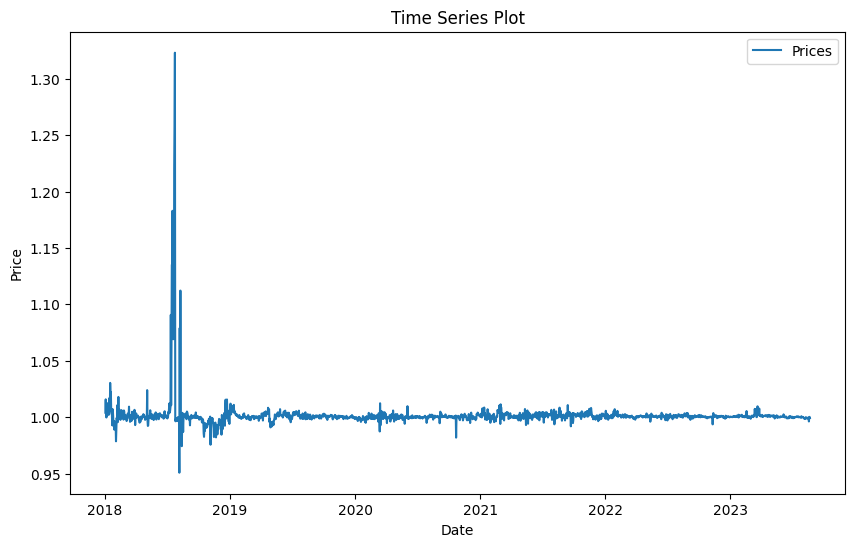

In [46]:


plt.figure(figsize=(10, 6), )
plt.plot(coin_market_chart.index, coin_market_chart["prices"], label="Prices")
# plt.plot(market_chart_coin_df.index, market_chart_coin_df["market_caps"], label="Market Caps")
# plt.plot(market_chart_coin_df.index, market_chart_coin_df["total_volumes"], label="Total Volumes")

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series Plot')
plt.legend()
plt.show()



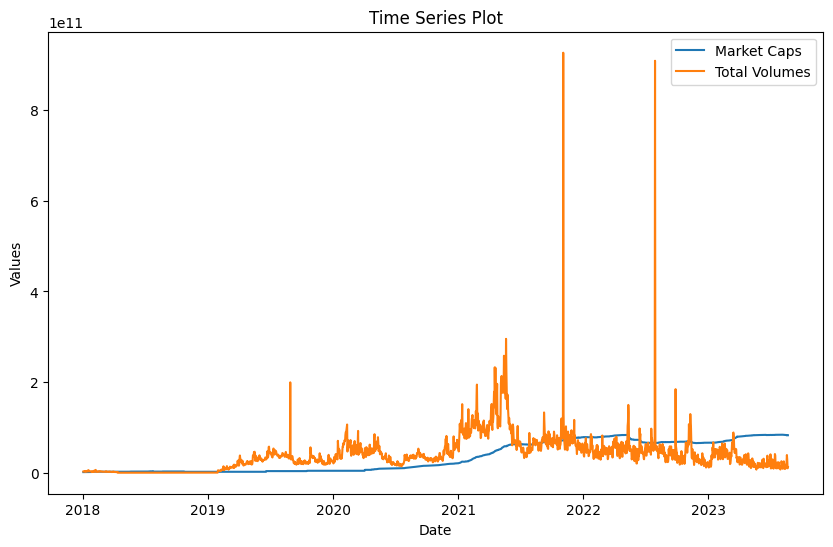

In [47]:
plt.figure(figsize=(10, 6))
#plt.plot(market_chart_coin_df.index, market_chart_coin_df["prices"], label="Prices")
plt.plot(coin_market_chart.index, coin_market_chart["market_caps"], label="Market Caps")
plt.plot(coin_market_chart.index, coin_market_chart["total_volumes"], label="Total Volumes")

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Plot')
plt.legend()
plt.show()

#### Getting more coins

The above code was for testing a the pipeline for a single coin. Now let's find more coins with data since 2018 by the usage of `df_from_market_chart_range()` function and the response of data_coins from the endpoint `coins_makerts`

In [33]:
coins_in_market = pd.DataFrame(data_coins)["id"].tolist()

NameError: name 'data_coins' is not defined

In [49]:
coins_in_market

['bitcoin',
 'ethereum',
 'tether',
 'binancecoin',
 'ripple',
 'usd-coin',
 'staked-ether',
 'cardano',
 'dogecoin',
 'solana',
 'tron',
 'polkadot',
 'matic-network',
 'shiba-inu',
 'litecoin',
 'the-open-network',
 'wrapped-bitcoin',
 'dai',
 'avalanche-2',
 'uniswap',
 'bitcoin-cash',
 'leo-token',
 'stellar',
 'chainlink',
 'binance-usd',
 'true-usd',
 'monero',
 'okb',
 'cosmos',
 'ethereum-classic',
 'hedera-hashgraph',
 'internet-computer',
 'filecoin',
 'lido-dao',
 'quant-network',
 'mantle',
 'crypto-com-chain',
 'aptos',
 'arbitrum',
 'vechain',
 'near',
 'optimism',
 'maker',
 'rocket-pool-eth',
 'the-graph',
 'kaspa',
 'aave',
 'xdce-crowd-sale',
 'frax',
 'whitebit',
 'algorand',
 'usdd',
 'elrond-erd-2',
 'immutable-x',
 'havven',
 'the-sandbox',
 'blockstack',
 'tezos',
 'injective-protocol',
 'eos',
 'axie-infinity',
 'theta-token',
 'bitcoin-cash-sv',
 'bitget-token',
 'flex-coin',
 'apecoin',
 'fantom',
 'decentraland',
 'radix',
 'render-token',
 'gatechain-token',

In [50]:
import time

coin_choices = []

request_counter = 0

step = 0

for coin in coins_in_market[:50]:

    print(step, end="\r")
    step += 1

    if df_from_market_chart_range(coin_id=coin, from_year=years_ranges[0][0], to_year=years_ranges[0][1]).shape[0] > 364:
        coin_choices.append(coin)

    request_counter += 1

    if request_counter == 10:

        request_counter = 0

        time.sleep(61)
        

In [61]:
len(coin_choices), coin_choices

(9,
 ['bitcoin',
  'ethereum',
  'tether',
  'tron',
  'litecoin',
  'bitcoin-cash',
  'stellar',
  'chainlink',
  'maker'])

In [62]:
years_ranges

[(1514786400, 1546322399),
 (1546322400, 1577858399),
 (1577858400, 1609480799),
 (1609480800, 1641016799),
 (1641016800, 1672552799),
 (1672552800, 1692582764)]

In [53]:
years_ranges[-1][1]

1692582764

In [54]:
bitcoin_df = year_paging(coin_id="bitcoin", years_ranges_list=years_ranges)

In [55]:
import sys
sys.getsizeof(bitcoin_df) / 1000000

0.494064

In [56]:
import time

market_chart_coins = []

for coin in coin_choices:
    
    coin_history_chart = {}

    coin_history_chart[coin] = year_paging(coin_id=coin, years_ranges_list=years_ranges)
    
    market_chart_coins.append(coin_history_chart)

    
    time.sleep(61)

In [32]:
def reshaping_market_chart(data_frame:pd.DataFrame):

    data_frame["dates"] = pd.to_datetime(data_frame["prices"].apply(lambda price: price[0]), unit="ms")
    data_frame["prices"] = data_frame["prices"].apply(lambda price: price[1])
    data_frame["market_caps"] = data_frame["market_caps"].apply(lambda market: market[1])
    data_frame["total_volumes"] = data_frame["total_volumes"].apply(lambda vol: vol[1])

In [ ]:
coin_choices[1:]

['ethereum',
 'tether',
 'binancecoin',
 'ripple',
 'usd-coin',
 'staked-ether',
 'cardano',
 'solana',
 'dogecoin']

In [ ]:
# for idx, val in enumerate(coin_choices):

#     reshaping_market_chart(market_chart_coins[idx][val])

In [ ]:
# bitcoin_df = market_chart_coins[0]["bitcoin"]
# ethereum_df = market_chart_coins[1]["ethereum"]
# tether_df = market_chart_coins[2]["tether"]
# binancecoin_df = market_chart_coins[3]["binancecoin"]
# ripple_df = market_chart_coins[4]["ripple"]
# usd_coin_df = market_chart_coins[5]["usd-coin"]
# staked_ether_df = market_chart_coins[6]["staked-ether"]
# cardano_df = market_chart_coins[7]["cardano"]
# solana_df = market_chart_coins[8]["solana"]
# dogecoin_df = market_chart_coins[9]["dogecoin"]


In [ ]:
# bitcoin_df.to_csv("data/bitcoin_df.csv")
# ethereum_df.to_csv("data/ethereum_df.csv")
# tether_df.to_csv("data/tether_df.csv")
# binancecoin_df.to_csv("data/binancecoin_df.csv")
# ripple_df.to_csv("data/ripple_df.csv")
# usd_coin_df.to_csv("data/usd_coin_df.csv")
# staked_ether_df.to_csv("data/staked_ether_df.csv")
# cardano_df.to_csv("data/cardano_df.csv")
# solana_df.to_csv("data/solana_df.csv")
# dogecoin_df.to_csv("data/dogecoin_df.csv")

In [35]:
bitcoin_df  =  pd.read_csv("data/bitcoin_df.csv", index_col=0)
ethereum_df  =  pd.read_csv("data/ethereum_df.csv", index_col=0)
tether_df  =  pd.read_csv("data/tether_df.csv", index_col=0)
binancecoin_df  =  pd.read_csv("data/binancecoin_df.csv", index_col=0)
ripple_df  =  pd.read_csv("data/ripple_df.csv", index_col=0)
usd_coin_df  =  pd.read_csv("data/usd_coin_df.csv", index_col=0)
staked_ether_df  =  pd.read_csv("data/staked_ether_df.csv", index_col=0)
cardano_df  =  pd.read_csv("data/cardano_df.csv", index_col=0)
solana_df  =  pd.read_csv("data/solana_df.csv", index_col=0)
dogecoin_df  =  pd.read_csv("data/dogecoin_df.csv", index_col=0)

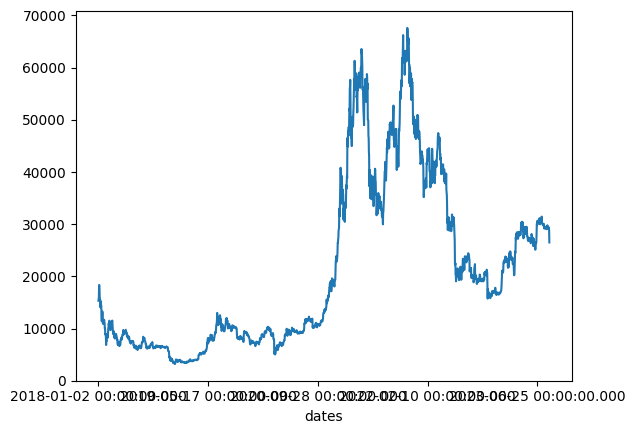

In [36]:
bitcoin_df.set_index("dates", drop=True)["prices"].plot();

<Axes: >

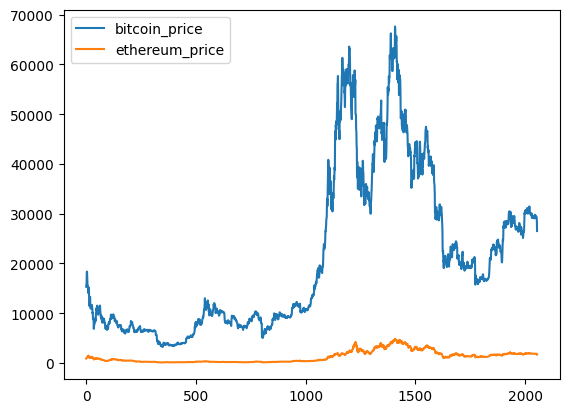

In [37]:
pd.concat([bitcoin_df["prices"].rename("bitcoin_price"), ethereum_df["prices"].rename("ethereum_price")], axis=1).plot()

### Creating Price DataFrame

In [38]:
import numpy as np
import pandas as pd

base_date = pd.to_datetime("2018-01-01")  # Replace with your desired start date
num_days = 2055  # Number of days
step_size = np.timedelta64(1, 'D')  # 1 day

date_linspace = base_date + np.arange(num_days) * step_size

date_linspace = pd.DataFrame(date_linspace).rename(columns={0:"dates"})
date_linspace["dates"] = date_linspace["dates"].dt.date

In [39]:
bitcoin_df["dates"] = pd.to_datetime(bitcoin_df["dates"]).dt.date 
ethereum_df["dates"] = pd.to_datetime(ethereum_df["dates"]).dt.date
tether_df["dates"] = pd.to_datetime(tether_df["dates"]).dt.date
binancecoin_df["dates"] = pd.to_datetime(binancecoin_df["dates"]).dt.date
ripple_df["dates"] = pd.to_datetime(ripple_df["dates"]).dt.date
usd_coin_df["dates"] = pd.to_datetime(usd_coin_df["dates"]).dt.date
staked_ether_df["dates"] = pd.to_datetime(staked_ether_df["dates"]).dt.date
cardano_df["dates"] = pd.to_datetime(cardano_df["dates"]).dt.date
solana_df["dates"] = pd.to_datetime(solana_df["dates"]).dt.date
dogecoin_df["dates"] = pd.to_datetime(dogecoin_df["dates"]).dt.date

In [40]:
date_linspace = date_linspace.merge(bitcoin_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "bitcoin_prices"})
date_linspace = date_linspace.merge(ethereum_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "ethereum_prices"})
date_linspace = date_linspace.merge(tether_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "tether_df_prices"})
date_linspace = date_linspace.merge(binancecoin_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "binancecoin_price"})
date_linspace = date_linspace.merge(ripple_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "ripple_prices"})
date_linspace = date_linspace.merge(usd_coin_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "usd_coin_prices"})
date_linspace = date_linspace.merge(staked_ether_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "staked_ether_prices"})
date_linspace = date_linspace.merge(cardano_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "cardano__prices"})
date_linspace = date_linspace.merge(solana_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "solana_prices"})
date_linspace = date_linspace.merge(dogecoin_df[["dates", "prices"]], on="dates", how="left").rename(columns={"prices": "dogecoin_prices"})

In [41]:
date_linspace.fillna(0)

,dates,bitcoin_prices,ethereum_prices,tether_df_prices,binancecoin_price,ripple_prices,usd_coin_prices,staked_ether_prices,cardano__prices,solana_prices,dogecoin_prices
0,2018-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2018-01-02,15321.932852,876.890259,1.003920,9.090393,2.455290,0.000000,0.000000,0.807430,0.000000,0.009335
2,2018-01-03,15583.885538,963.055751,1.015780,9.886323,3.125710,0.000000,0.000000,1.075401,0.000000,0.009592
3,2018-01-04,15976.365194,978.416104,1.002740,9.675758,3.220050,0.000000,0.000000,1.179347,0.000000,0.010098
4,2018-01-05,18336.922980,1004.894972,0.999695,16.488523,2.931380,0.000000,0.000000,1.077821,0.000000,0.013841
...,...,...,...,...,...,...,...,...,...,...,...
2050,2023-08-13,29412.142275,1848.505239,0.999377,240.088445,0.627081,0.999880,1846.710998,0.291666,24.891819,0.076696
2051,2023-08-14,29284.969714,1839.512810,0.999384,240.030792,0.625689,0.999981,1837.912572,0.289372,24.223294,0.074778
2052,2023-08-15,29400.586804,1843.513391,0.998713,240.358056,0.634681,0.999688,1842.552503,0.290452,25.147725,0.074764
2053,2023-08-16,29170.490397,1826.913128,0.998893,236.607285,0.609330,0.999975,1826.361340,0.281729,23.875641,0.070818


In [42]:
def percentage_null(data_frame: pd.DataFrame | pd.Series):
    return round((data_frame.isna().sum().sort_values(ascending=False) / data_frame.shape[0] * 100),2)

In [43]:
percentage_null(date_linspace)

staked_ether_prices    52.85
solana_prices          40.44
usd_coin_prices        13.48
tether_df_prices        0.10
bitcoin_prices          0.05
ethereum_prices         0.05
binancecoin_price       0.05
ripple_prices           0.05
cardano__prices         0.05
dogecoin_prices         0.05
dates                   0.00
dtype: float64

In [44]:
def plot_range_price(data_frame:pd.DataFrame, columns:list, start_date:str, periods:int):

    return (data_frame.set_index("dates")
                        # Filtering settings
                    .loc[pd.date_range(start=start_date, periods=periods, freq='D'),
                            columns
                            ]
                        # Plotting settings
                    .plot(
                        figsize=(25, 10),
                        linewidth=3
                    ));

In [45]:
date_linspace.columns

Index(['dates', 'bitcoin_prices', 'ethereum_prices', 'tether_df_prices',
       'binancecoin_price', 'ripple_prices', 'usd_coin_prices',
       'staked_ether_prices', 'cardano__prices', 'solana_prices',
       'dogecoin_prices'],
      dtype='object')

# Filling date for continuity


If we were to attempt to filter through dates.. maybe there will some missing dates in the linspace.. for example the crupto currency solana has some dates missing..

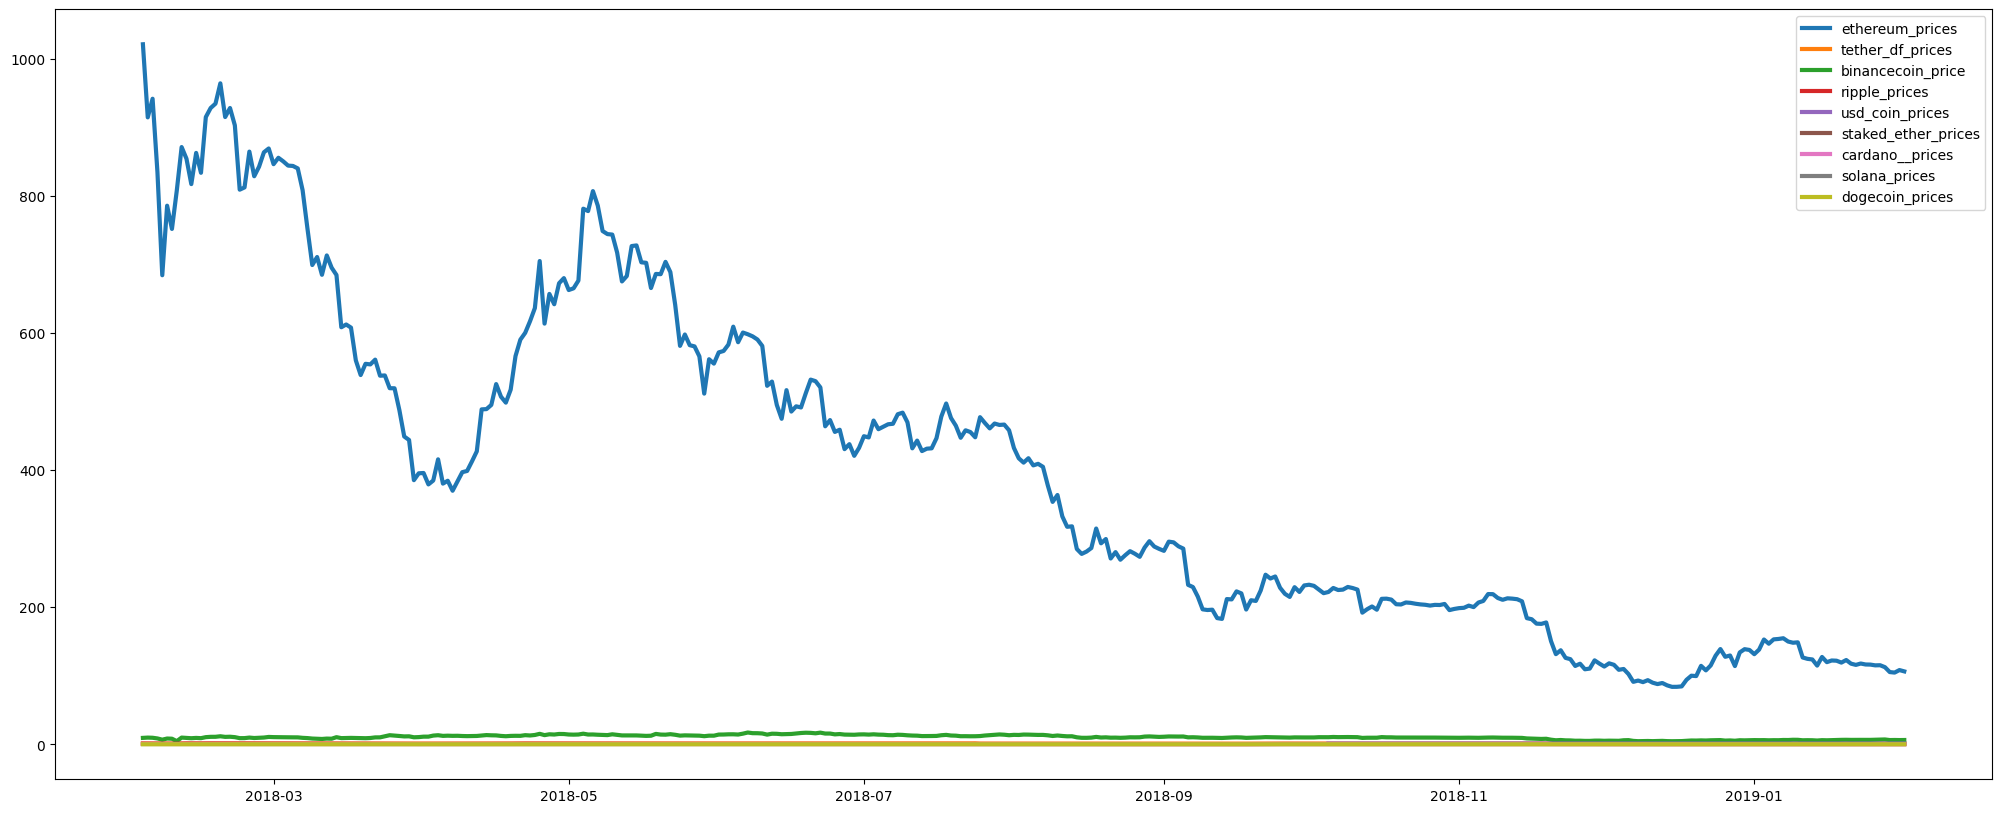

In [46]:
plot_range_price(date_linspace,columns=['ethereum_prices', 'tether_df_prices',
        'binancecoin_price', 'ripple_prices', 'usd_coin_prices',
        'staked_ether_prices', 'cardano__prices', 'solana_prices',
        'dogecoin_prices'], start_date="2018-02-02", periods=365);

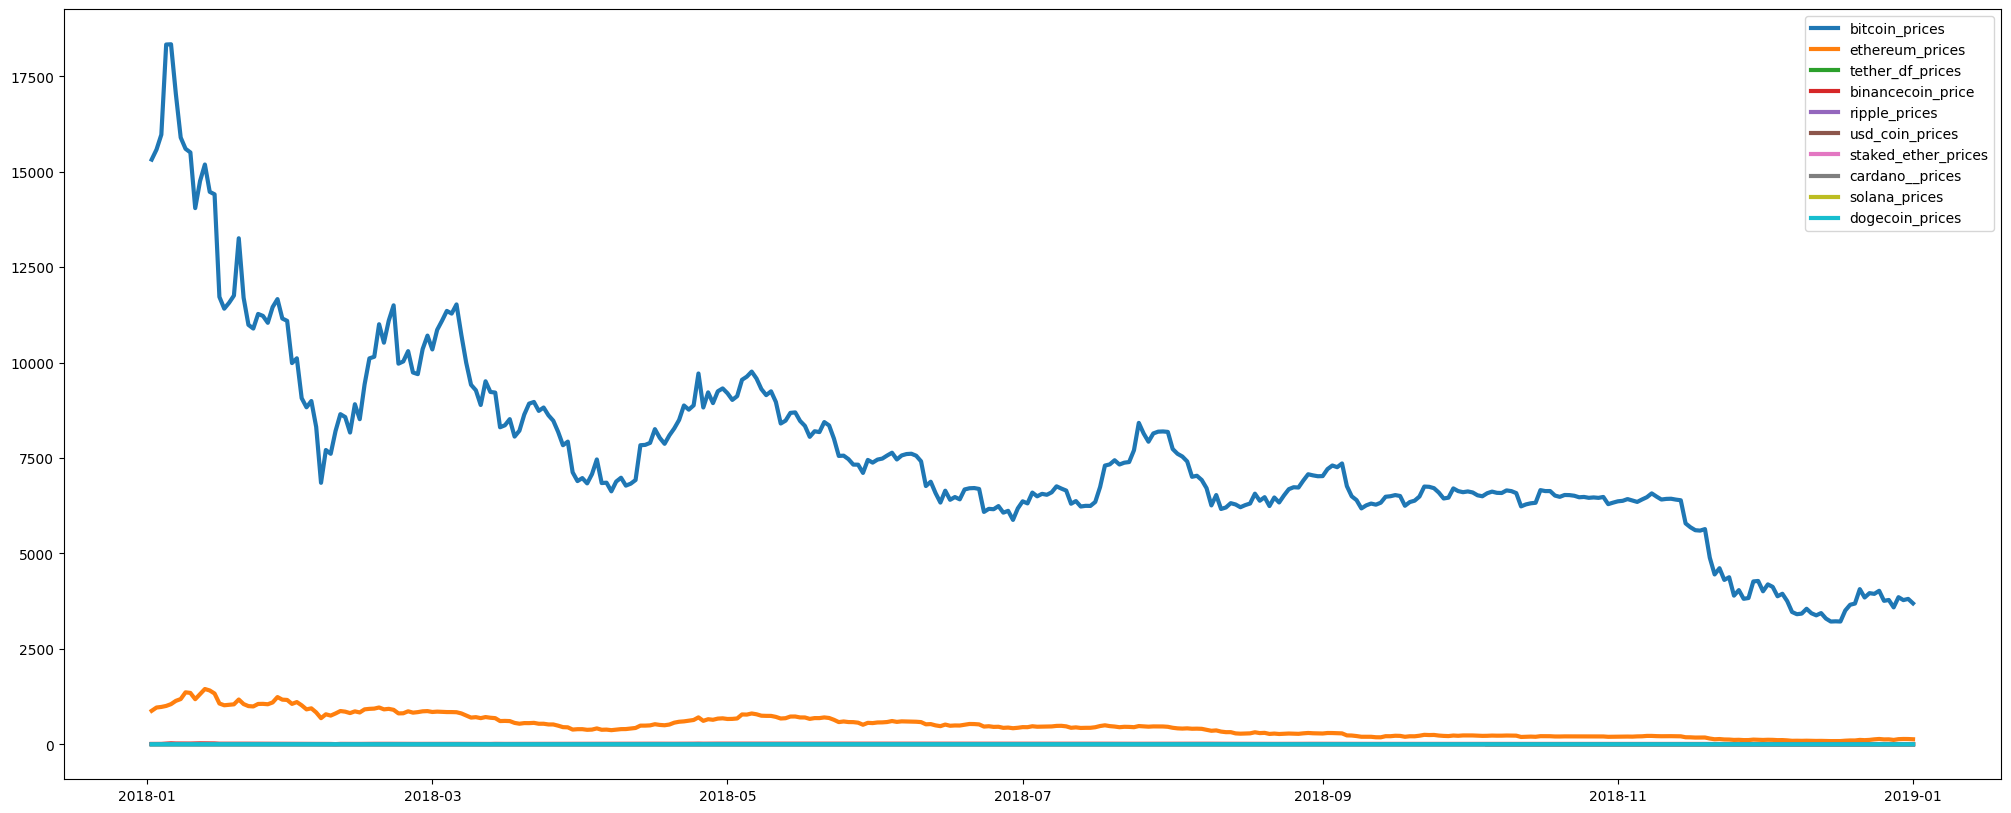

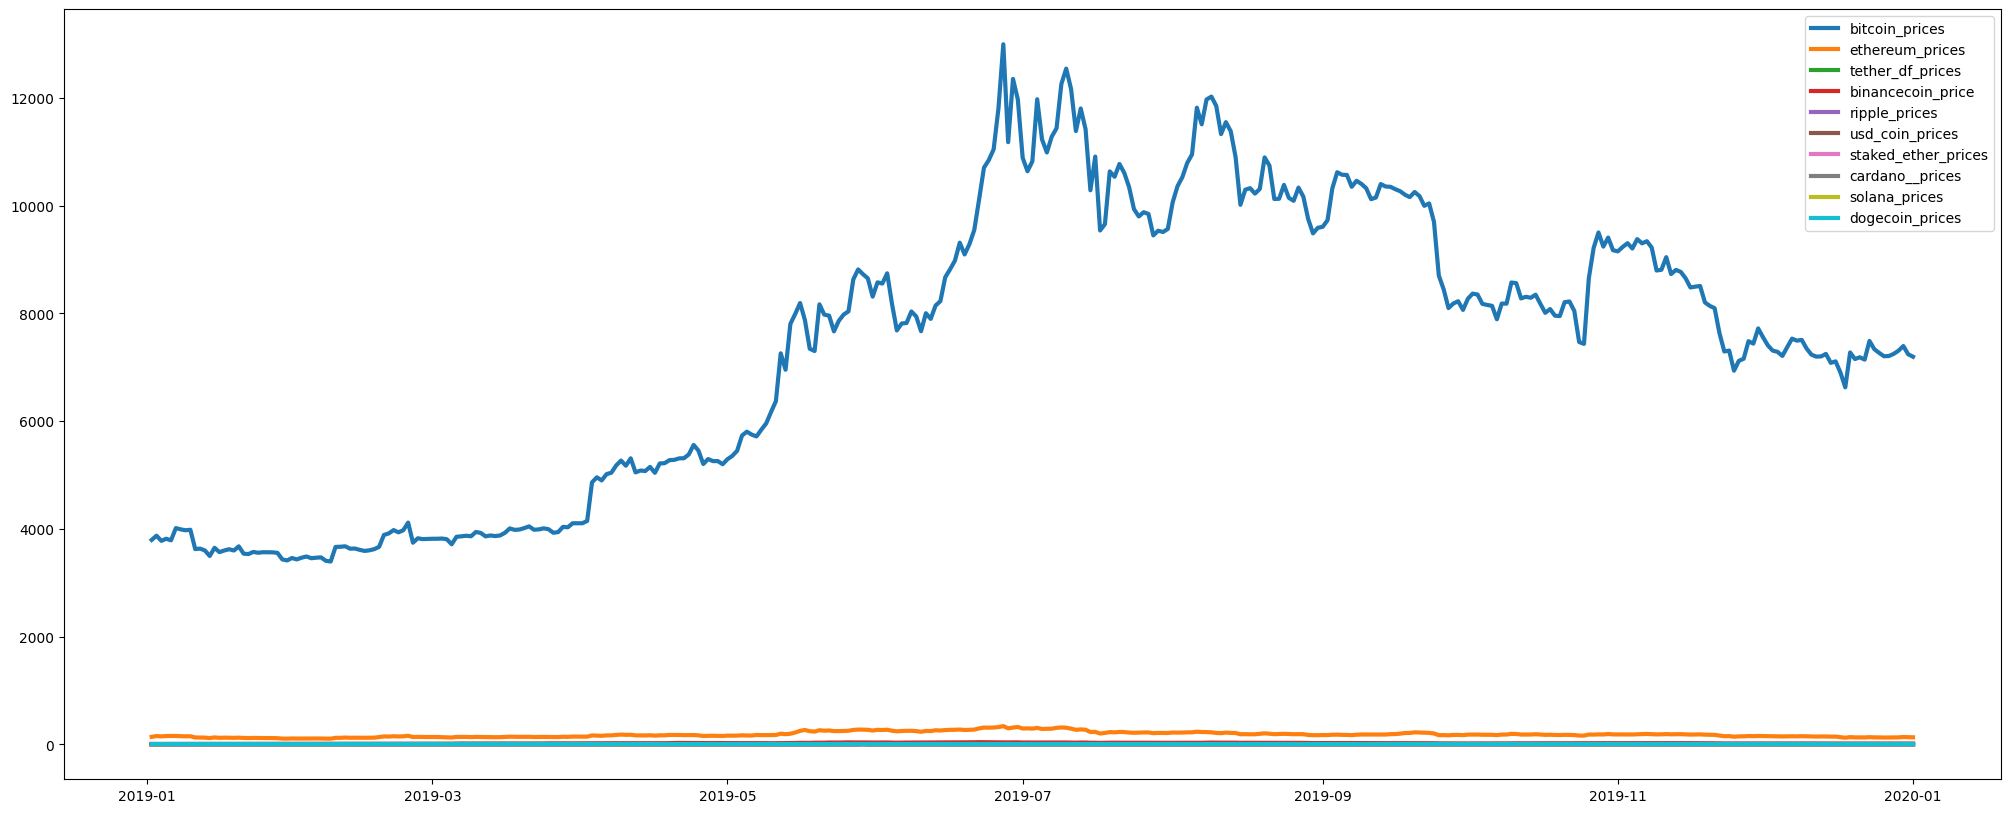

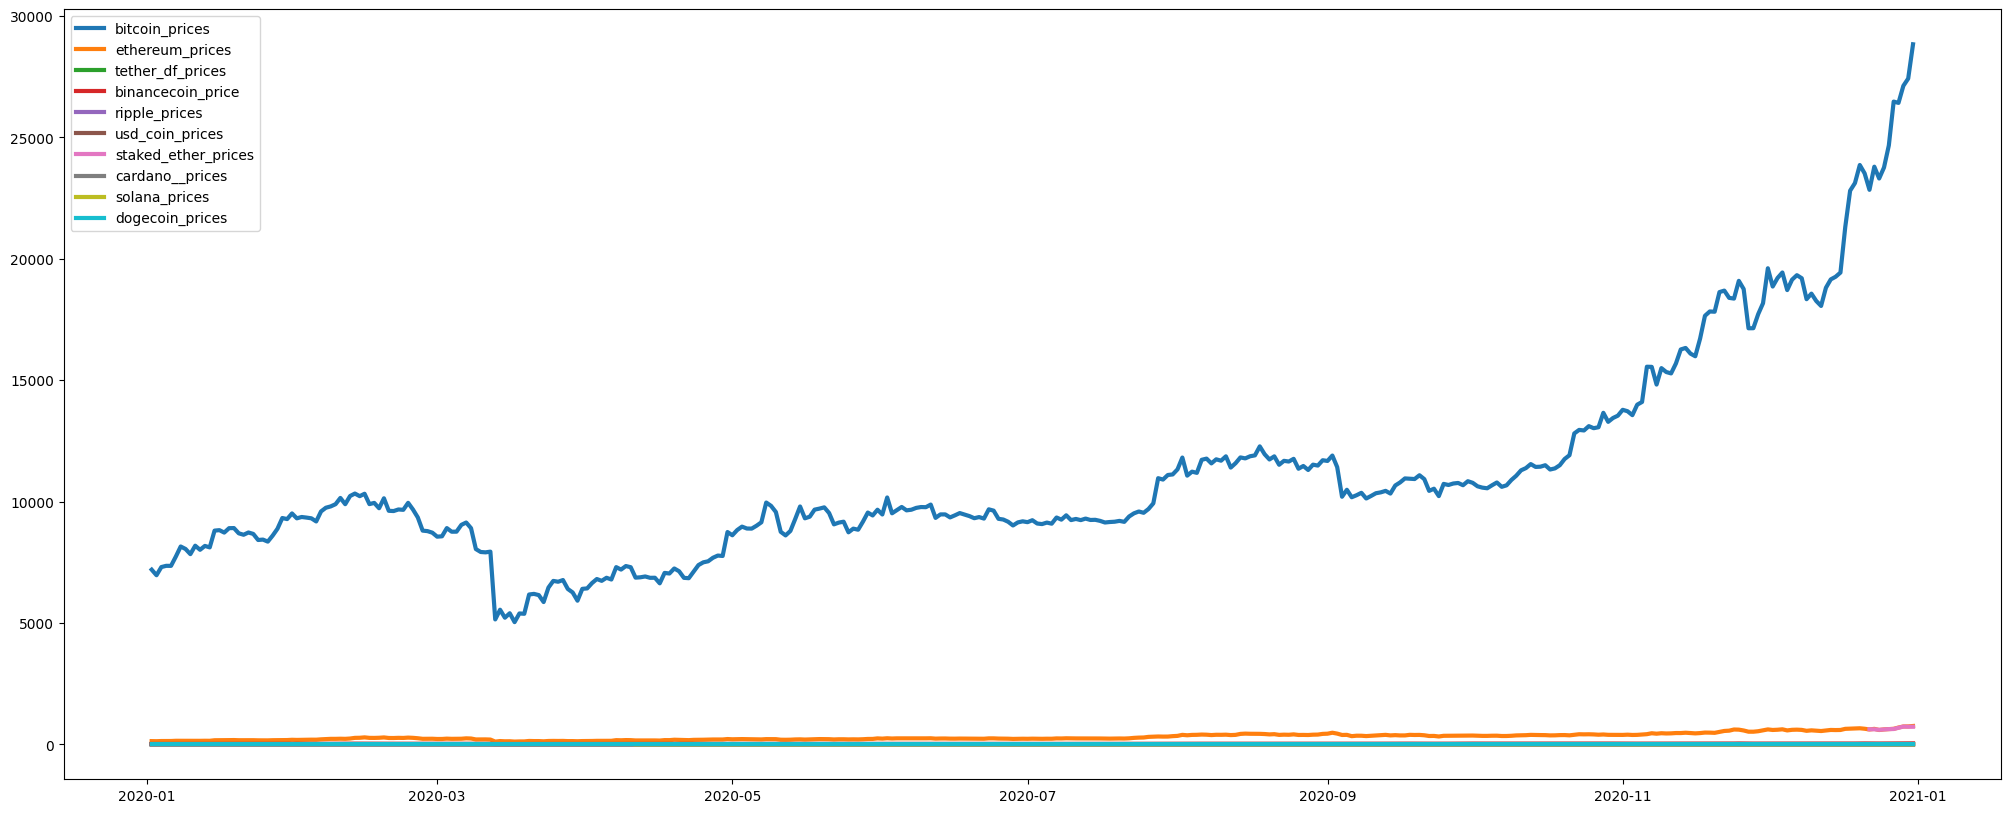

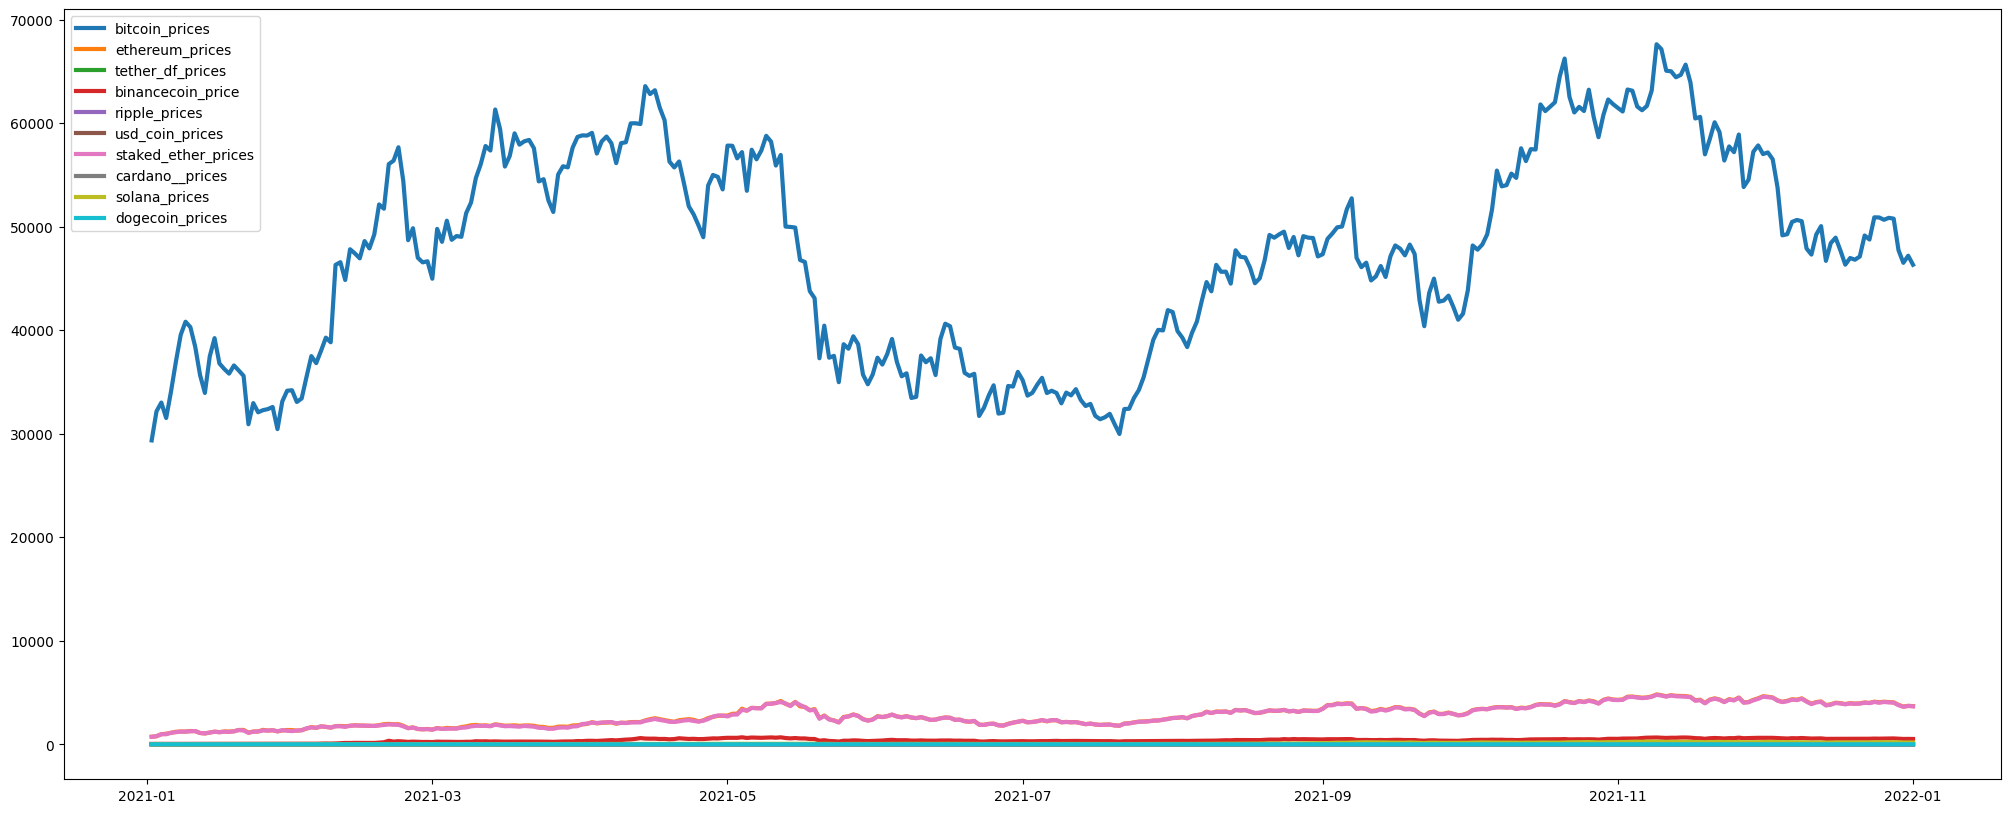

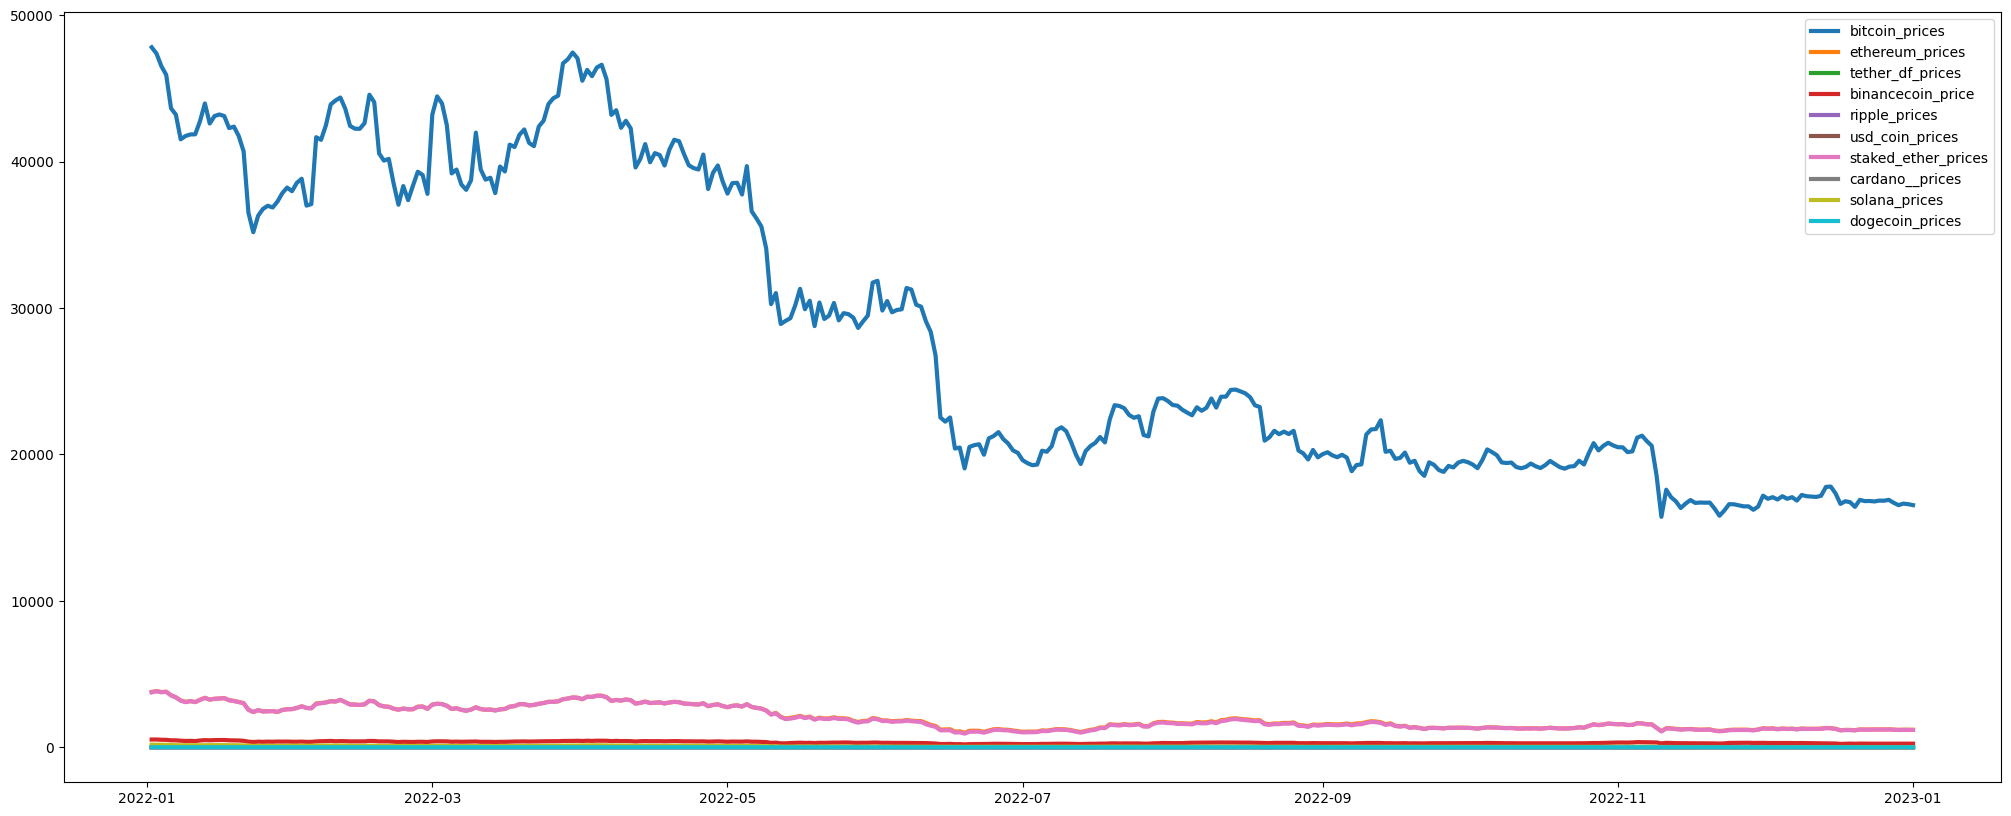

In [47]:
for year_number in range(2018, 2023):

    year_number = str(year_number)

    date_string = f'{year_number}-01-02'

    plot_range_price(date_linspace, columns=['bitcoin_prices','ethereum_prices', 'tether_df_prices',
        'binancecoin_price', 'ripple_prices', 'usd_coin_prices',
        'staked_ether_prices', 'cardano__prices', 'solana_prices',
        'dogecoin_prices'], start_date=date_string, periods=365);

In [48]:
base_date = pd.to_datetime("2018-01-01")  # Replace with your desired start date
num_days = 2055  # Number of days
step_size = np.timedelta64(1, 'D')  # 1 day

date_linspace_1 = base_date + np.arange(num_days) * step_size

date_linspace_1 = pd.DataFrame(date_linspace_1).rename(columns={0:"dates"})
date_linspace_1["dates"] = date_linspace_1["dates"].dt.date

In [49]:
date_linspace_1

,dates
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
2050,2023-08-13
2051,2023-08-14
2052,2023-08-15
2053,2023-08-16


In [50]:
bitcoin_df.columns

Index(['prices', 'market_caps', 'total_volumes', 'dates'], dtype='object')

In [51]:
date_linspace_1 = date_linspace_1.merge(bitcoin_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "bitcoin_market_cap", "total_volumes": "bitcoin_total_volumes"})
date_linspace_1 = date_linspace_1.merge(ethereum_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "ethereum_market_cap", "total_volumes": "ethereum_total_volumes"})
date_linspace_1 = date_linspace_1.merge(tether_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "tether_df_market_cap", "total_volumes": "tether_df_total_volumes"})
date_linspace_1 = date_linspace_1.merge(binancecoin_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "binancecoinmarket_cap", "total_volumes": "binancecointotal_volumes"})
date_linspace_1 = date_linspace_1.merge(ripple_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "ripple_market_cap", "total_volumes": "ripple_total_volumes"})
date_linspace_1 = date_linspace_1.merge(usd_coin_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "usd_coin_market_cap", "total_volumes": "usd_coin_total_volumes"})
date_linspace_1 = date_linspace_1.merge(staked_ether_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "staked_ether_market_cap", "total_volumes": "staked_ether_total_volumes"})
date_linspace_1 = date_linspace_1.merge(cardano_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "cardano__market_cap", "total_volumes": "cardano__total_volumes"})
date_linspace_1 = date_linspace_1.merge(solana_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "solana_market_cap", "total_volumes": "solana_total_volumes"})
date_linspace_1 = date_linspace_1.merge(dogecoin_df[["dates", "market_caps", "total_volumes"]], on="dates", how="left").rename(columns={"market_caps": "dogecoin_market_cap", "total_volumes": "dogecoin_total_volumes"})

In [52]:
date_linspace_1.columns

Index(['dates', 'bitcoin_market_cap', 'bitcoin_total_volumes',
       'ethereum_market_cap', 'ethereum_total_volumes', 'tether_df_market_cap',
       'tether_df_total_volumes', 'binancecoinmarket_cap',
       'binancecointotal_volumes', 'ripple_market_cap', 'ripple_total_volumes',
       'usd_coin_market_cap', 'usd_coin_total_volumes',
       'staked_ether_market_cap', 'staked_ether_total_volumes',
       'cardano__market_cap', 'cardano__total_volumes', 'solana_market_cap',
       'solana_total_volumes', 'dogecoin_market_cap',
       'dogecoin_total_volumes'],
      dtype='object')

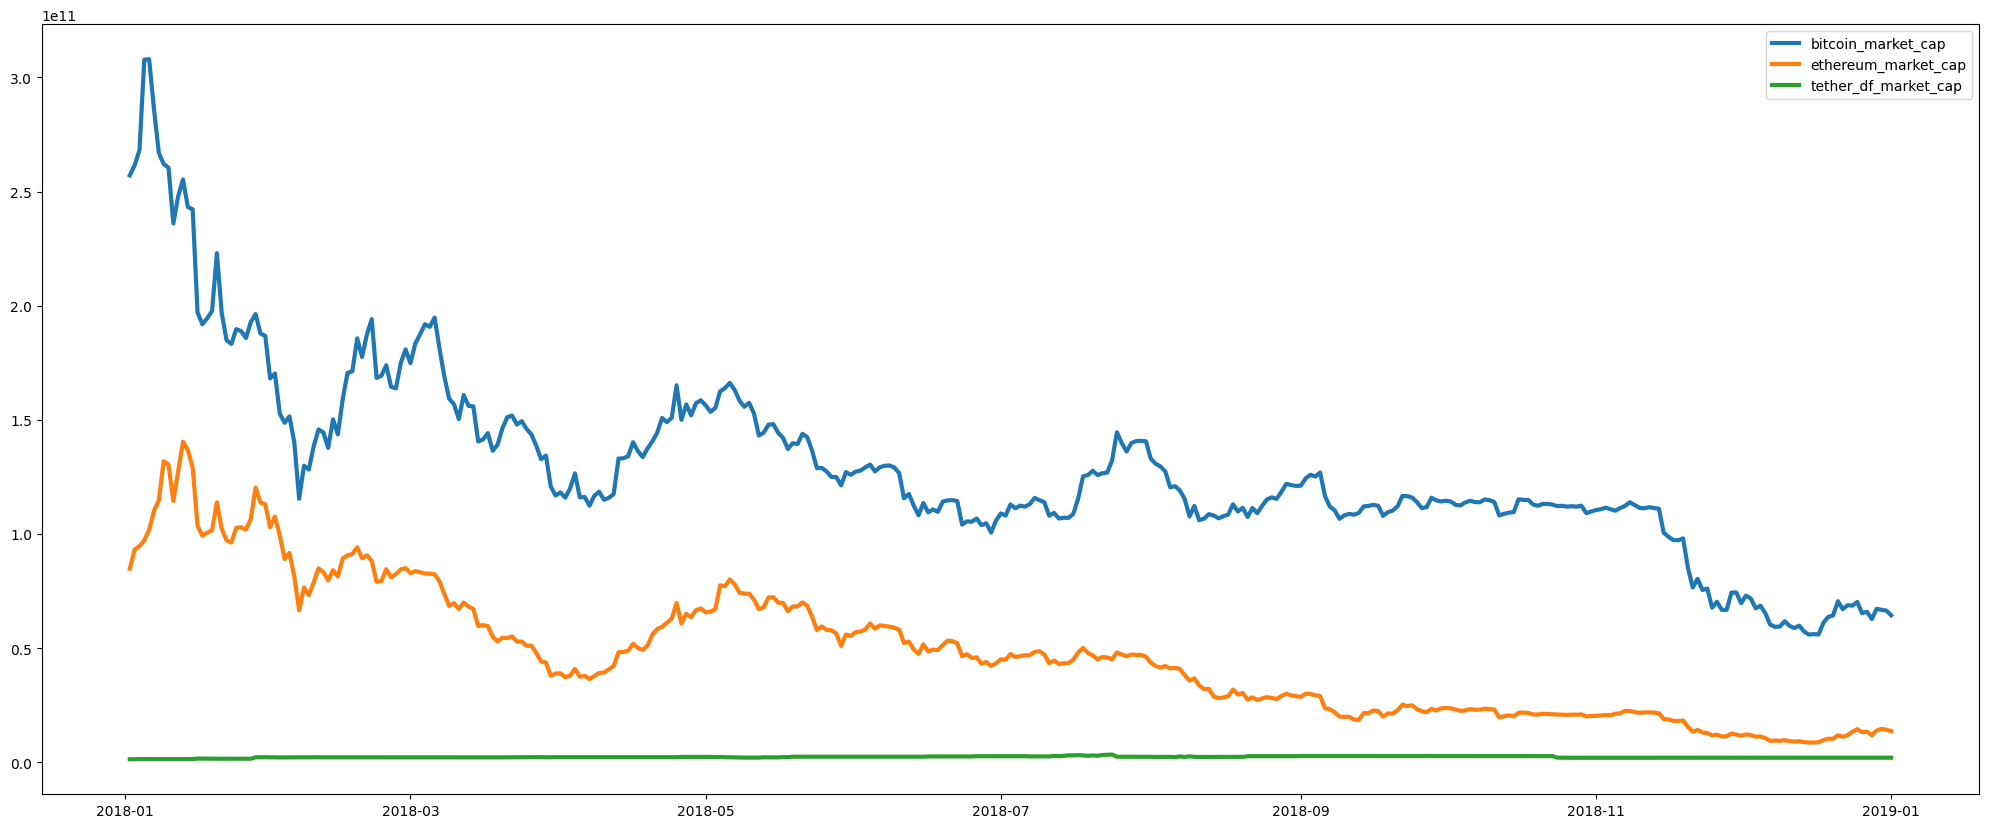

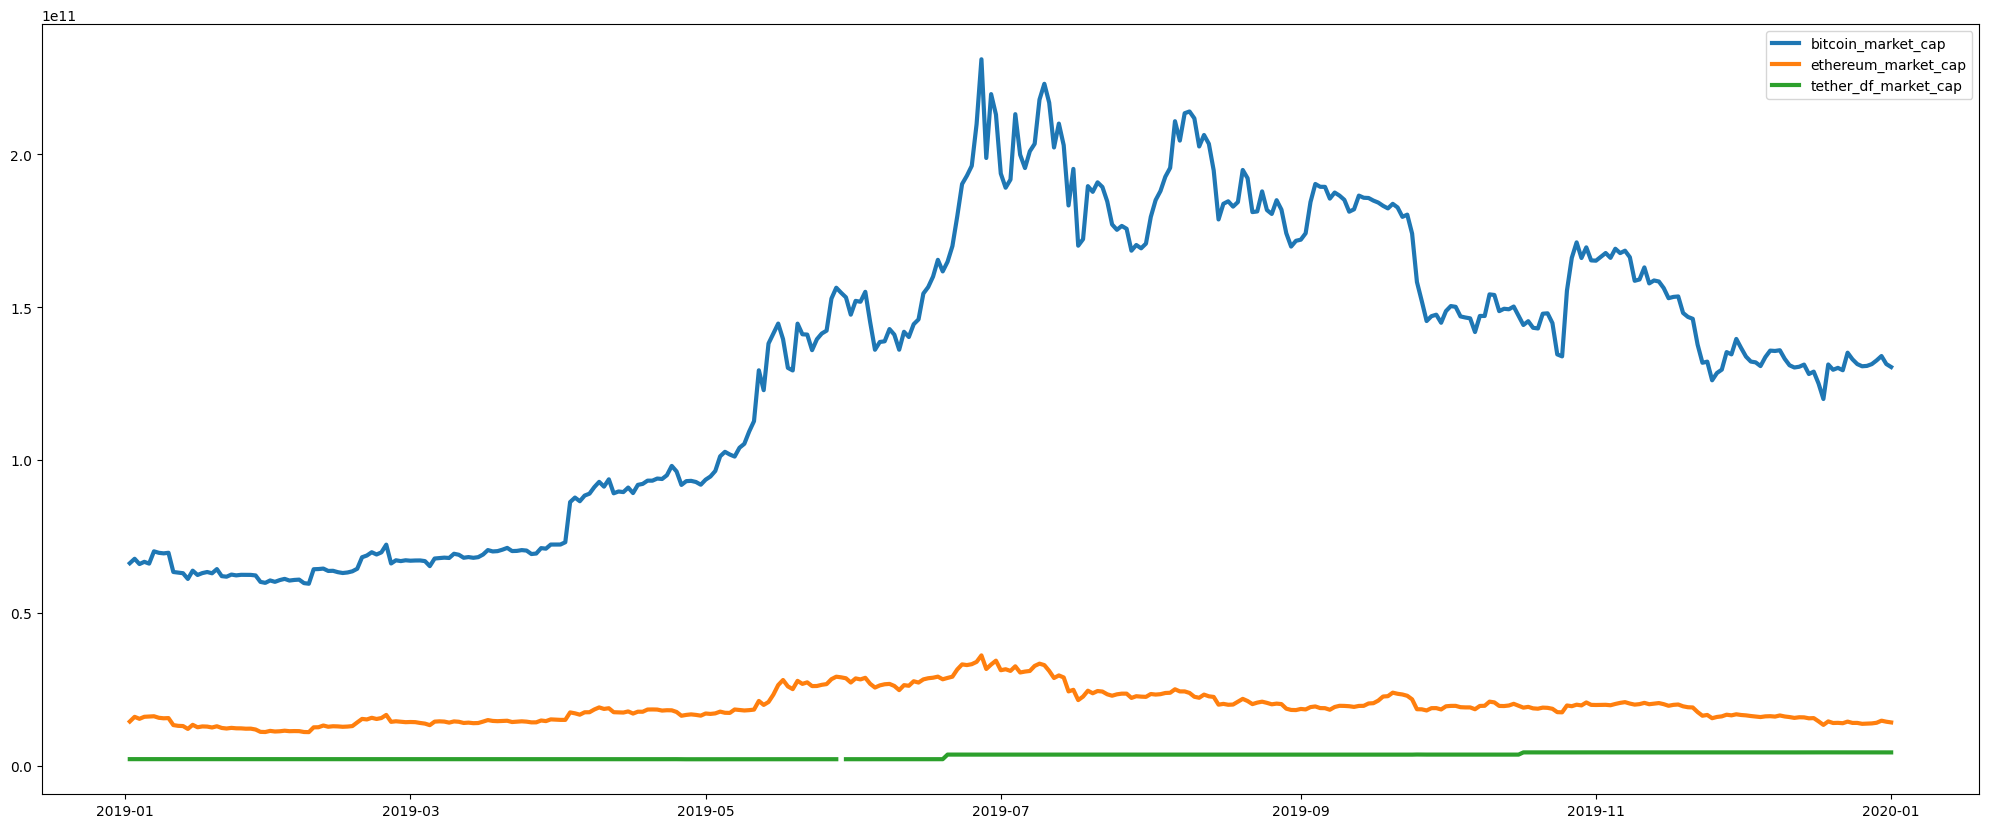

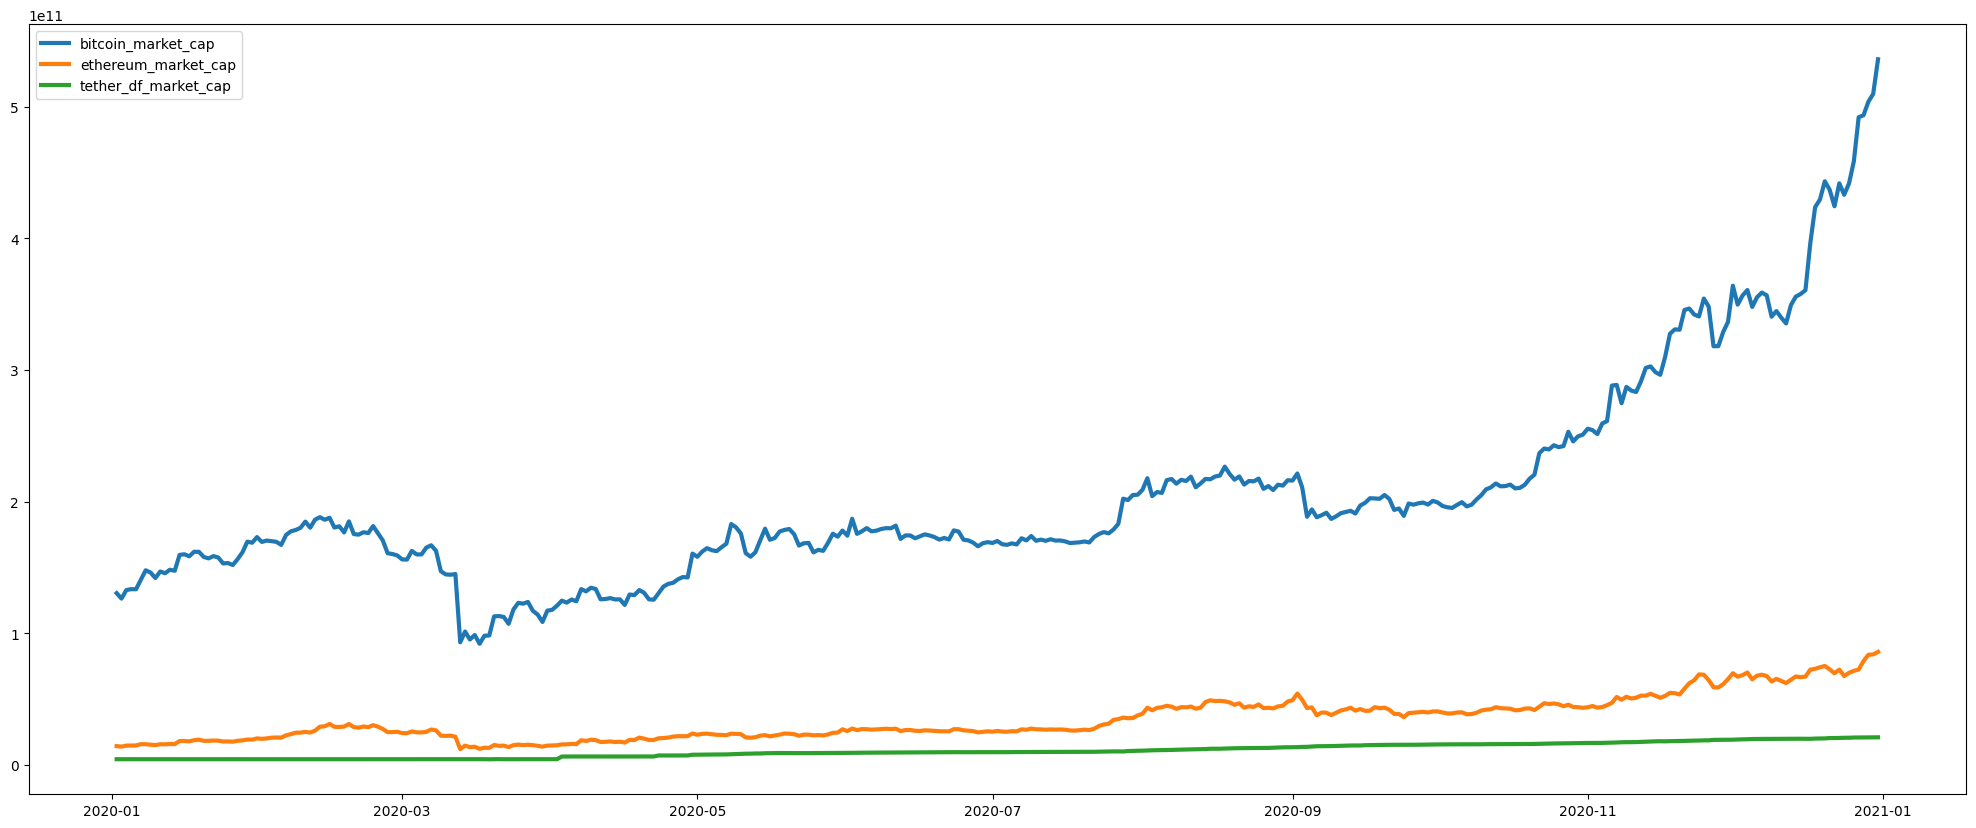

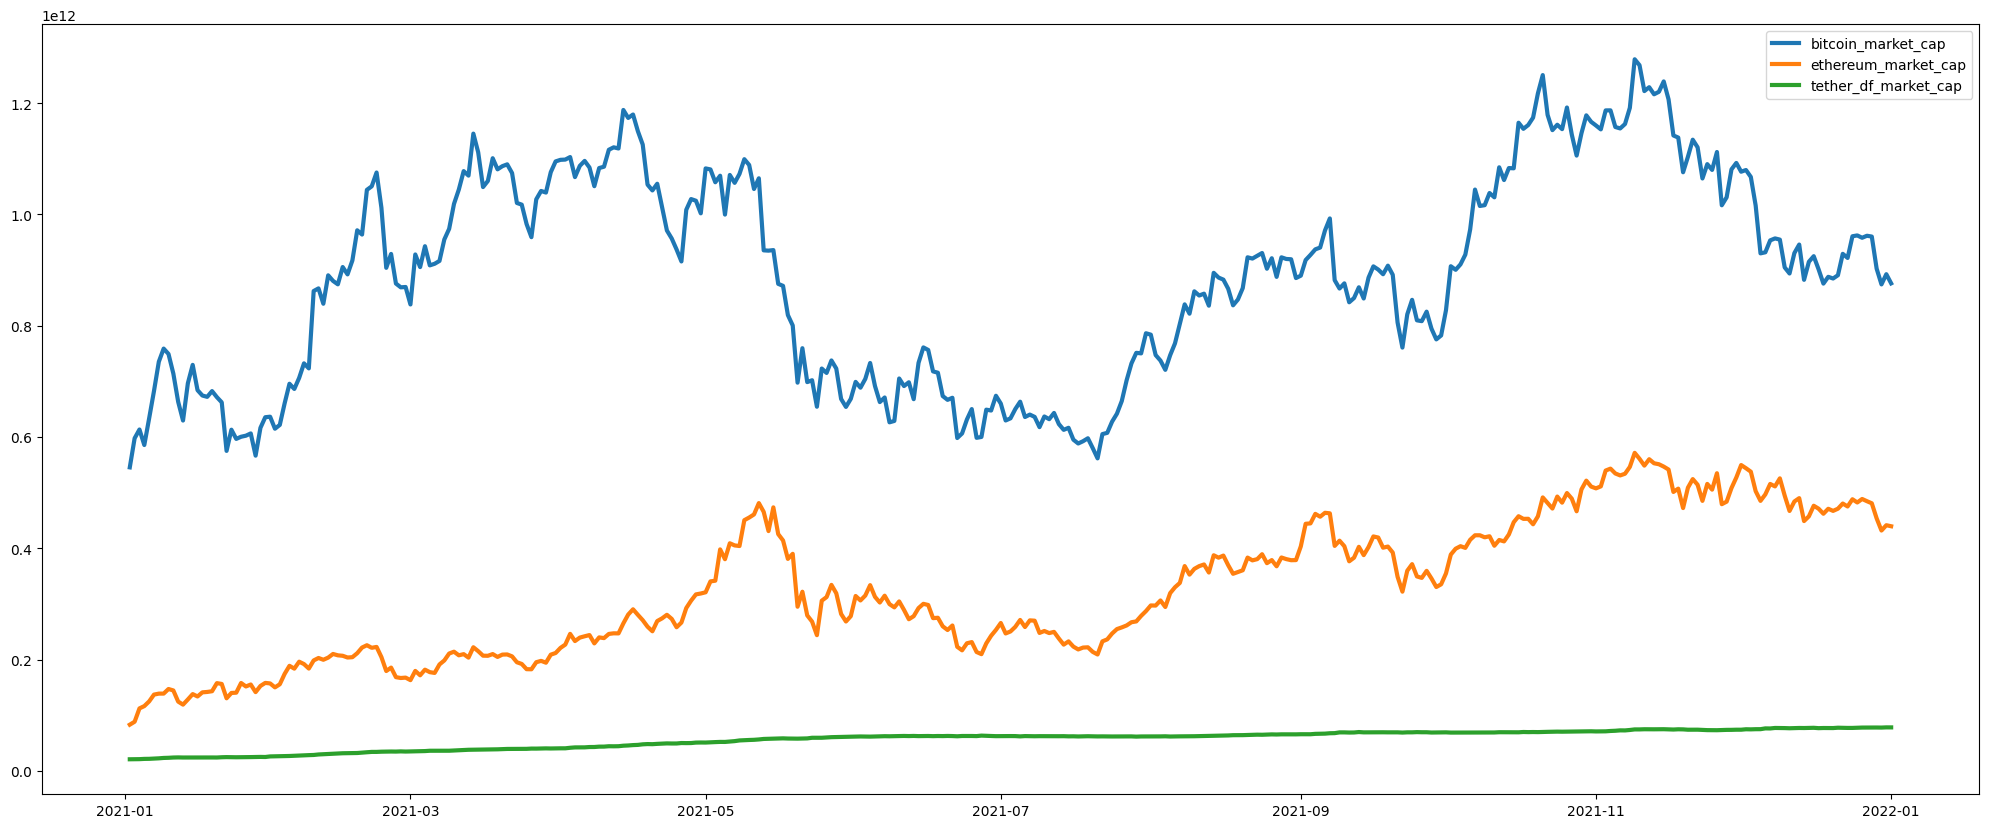

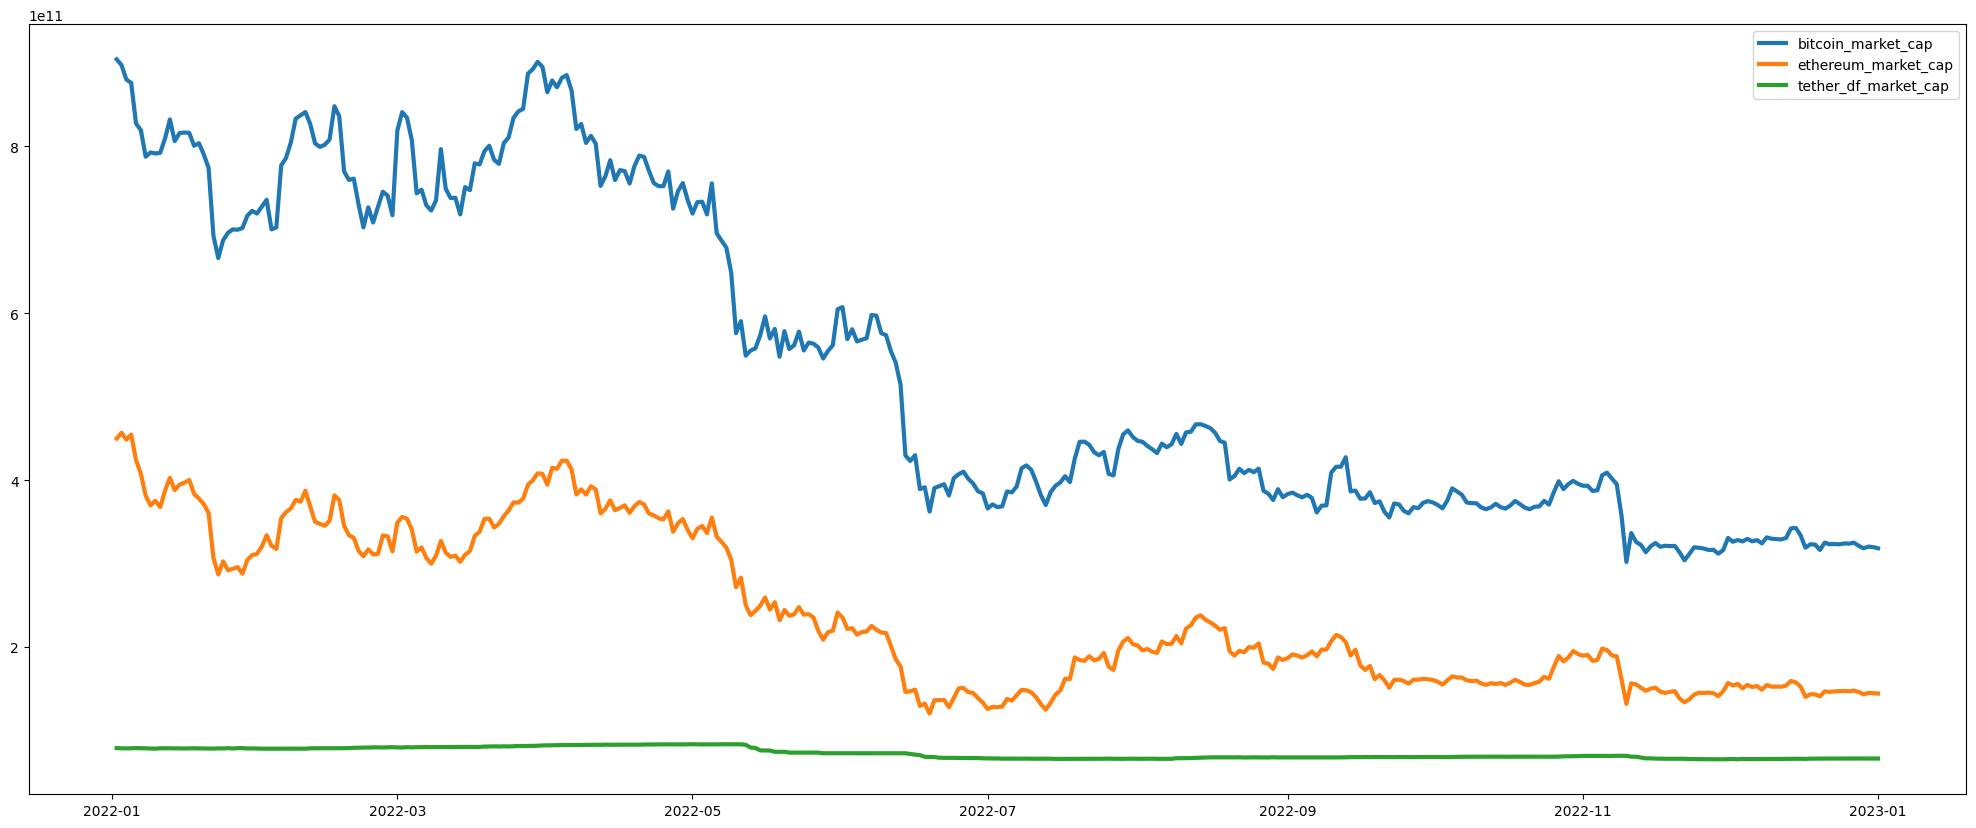

In [53]:
for year_number in range(2018, 2023):

    year_number = str(year_number)

    date_string = f'{year_number}-01-02'

    plot_range_price(date_linspace_1, columns=['bitcoin_market_cap', 'ethereum_market_cap', 'tether_df_market_cap'], start_date=date_string, periods=365);

In [54]:
date_linspace_1

,dates,bitcoin_market_cap,bitcoin_total_volumes,ethereum_market_cap,ethereum_total_volumes,tether_df_market_cap,tether_df_total_volumes,binancecoinmarket_cap,binancecointotal_volumes,ripple_market_cap,...,usd_coin_market_cap,usd_coin_total_volumes,staked_ether_market_cap,staked_ether_total_volumes,cardano__market_cap,cardano__total_volumes,solana_market_cap,solana_total_volumes,dogecoin_market_cap,dogecoin_total_volumes
0,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,2.570796e+11,4.130218e+09,8.482222e+10,2.720973e+09,1.373453e+09,2.632020e+09,9.000762e+08,6.127175e+07,9.511583e+10,...,NaN,NaN,NaN,NaN,2.093430e+10,2.901483e+08,NaN,NaN,1.051233e+09,6.782355e+07
2,2018-01-03,2.615052e+11,3.310356e+09,9.317853e+10,2.308657e+09,1.389678e+09,2.461680e+09,9.788844e+08,5.327417e+07,1.210873e+11,...,NaN,NaN,NaN,NaN,2.788200e+10,6.721725e+08,NaN,NaN,1.080254e+09,5.158160e+07
3,2018-01-04,2.681247e+11,4.217387e+09,9.468115e+10,2.756635e+09,1.472112e+09,3.203460e+09,9.580355e+08,9.342065e+07,1.247420e+11,...,NaN,NaN,NaN,NaN,3.057701e+10,5.878658e+08,NaN,NaN,1.137418e+09,8.583633e+07
4,2018-01-05,3.077740e+11,6.275688e+09,9.726923e+10,2.894789e+09,1.467642e+09,3.096040e+09,1.632595e+09,3.374991e+08,1.135592e+11,...,NaN,NaN,NaN,NaN,2.794475e+10,5.074352e+08,NaN,NaN,1.559193e+09,1.574593e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,2023-08-13,5.722578e+11,3.994298e+09,2.220698e+11,2.215987e+09,8.335542e+10,9.189020e+09,3.694355e+10,1.952054e+08,3.309347e+10,...,2.616194e+10,1.242418e+09,1.493331e+10,2.289124e+06,1.021759e+10,1.056080e+08,1.009565e+10,2.773069e+08,1.077445e+10,3.855159e+08
2051,2023-08-14,5.696871e+11,4.755220e+09,2.209483e+11,3.642425e+09,8.330329e+10,9.254138e+09,3.691382e+10,2.307638e+08,3.302093e+10,...,2.618058e+10,1.681827e+09,1.487713e+10,3.616812e+06,1.013505e+10,1.251063e+08,9.839555e+09,2.781821e+08,1.050395e+10,3.255308e+08
2052,2023-08-15,5.722427e+11,1.240836e+10,2.215642e+11,4.495325e+09,8.332348e+10,1.279237e+10,3.697023e+10,3.232128e+08,3.352678e+10,...,2.600436e+10,2.461886e+09,1.493220e+10,5.027849e+06,1.018196e+10,1.298745e+08,1.021132e+10,3.880259e+08,1.051512e+10,4.339586e+08
2053,2023-08-16,5.674983e+11,1.152340e+10,2.194728e+11,4.416612e+09,8.308914e+10,1.874669e+10,3.644085e+10,4.801982e+08,3.215351e+10,...,2.603284e+10,3.215612e+09,1.484988e+10,1.829936e+07,9.874705e+09,1.741227e+08,9.697572e+09,4.525215e+08,9.960604e+09,4.857363e+08


In [55]:
date_linspace_1.columns

Index(['dates', 'bitcoin_market_cap', 'bitcoin_total_volumes',
       'ethereum_market_cap', 'ethereum_total_volumes', 'tether_df_market_cap',
       'tether_df_total_volumes', 'binancecoinmarket_cap',
       'binancecointotal_volumes', 'ripple_market_cap', 'ripple_total_volumes',
       'usd_coin_market_cap', 'usd_coin_total_volumes',
       'staked_ether_market_cap', 'staked_ether_total_volumes',
       'cardano__market_cap', 'cardano__total_volumes', 'solana_market_cap',
       'solana_total_volumes', 'dogecoin_market_cap',
       'dogecoin_total_volumes'],
      dtype='object')

In [56]:
def marketcap_vs_totalvolumes(dataframe:pd.DataFrame, columns:list):
    return dataframe[columns].sum().plot(kind="pie", subplots=True);

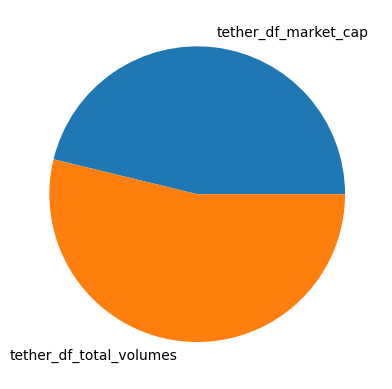

In [59]:
marketcap_vs_totalvolumes(dataframe=date_linspace_1, columns=[ 'tether_df_market_cap',
       'tether_df_total_volumes']);